In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Re-using the ResBlock, Attention, and DecoderBlock from previous model ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1), nn.BatchNorm2d(out_channels))
        else:
            self.shortcut = nn.Identity()
    def forward(self, x):
        identity = self.shortcut(x); out = F.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out)); out += identity; return F.relu(out)

class SimplifiedAttention(nn.Module):
    def __init__(self, channels):
        super().__init__(); self.attention = nn.Sequential(nn.Conv2d(channels, channels // 8, 1), nn.ReLU(True), nn.Conv2d(channels // 8, channels, 1), nn.Sigmoid())
    def forward(self, x): return x * self.attention(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_attention=False):
        super().__init__(); self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2); self.res_block = ResBlock(out_channels + skip_channels, out_channels); self.attention = SimplifiedAttention(out_channels) if use_attention else nn.Identity()
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape: x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1); x = self.res_block(x); return self.attention(x)

class HiP_EEF_Direct(nn.Module):
    """
    Final HiP-EEF architecture for Direct Residual Prediction.
    This version removes the Gating Head for simpler, direct supervision.
    """
    def __init__(self, n_channels=4, base_c=32):
        super().__init__()
        # --- Shared Encoder (Unchanged) ---
        self.enc1 = ResBlock(n_channels, base_c); self.enc2 = ResBlock(base_c, base_c * 2); self.enc3 = ResBlock(base_c * 2, base_c * 4); self.enc4 = ResBlock(base_c * 4, base_c * 8); self.down = nn.MaxPool2d(2)
        self.bottleneck = ResBlock(base_c * 8, base_c * 16)

        # --- Continuity Head Decoder (Unchanged) ---
        self.up1_cont = DecoderBlock(base_c * 16, base_c * 8, base_c * 8); self.up2_cont = DecoderBlock(base_c * 8, base_c * 4, base_c * 4); self.up3_cont = DecoderBlock(base_c * 4, base_c * 2, base_c * 2); self.up4_cont = DecoderBlock(base_c * 2, base_c, base_c); self.out_cont = nn.Conv2d(base_c, 1, kernel_size=1)

        # --- Extreme Event Head Decoder (Unchanged) ---
        self.up1_ext = DecoderBlock(base_c * 16, base_c * 8, base_c * 8); self.up2_ext = DecoderBlock(base_c * 8, base_c * 4, base_c * 4, use_attention=True); self.up3_ext = DecoderBlock(base_c * 4, base_c * 2, base_c * 2); self.up4_ext = DecoderBlock(base_c * 2, base_c, base_c); self.out_ext = nn.Conv2d(base_c, 1, kernel_size=1)

    def forward(self, x):
        # --- Encoder Path ---
        s1 = self.enc1(x); s2 = self.enc2(self.down(s1)); s3 = self.enc3(self.down(s2)); s4 = self.enc4(self.down(s3))
        b = self.bottleneck(self.down(s4))

        # --- Decoder Paths ---
        c4 = self.up1_cont(b, s4); c3 = self.up2_cont(c4, s3); c2 = self.up3_cont(c3, s2); c1 = self.up4_cont(c2, s1)
        cont_pred = self.out_cont(c1)

        e4 = self.up1_ext(b, s4); e3 = self.up2_ext(e4, s3); e2 = self.up3_ext(e3, s2); e1 = self.up4_ext(e2, s1)
        ext_pred = self.out_ext(e1)

        # --- Simple Fusion ---
        final_pred = cont_pred + ext_pred

        return final_pred, cont_pred, ext_pred


In [2]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import joblib

class MultiVariableARDataset(Dataset):
    """
    A flexible dataset for the AR Downscaling project that loads all available
    predictor variables and the target variable.

    The selection of specific variables (e.g., for ablation or the HiP-EEF model)
    is handled within the training script, not in the dataset itself.
    """
    def __init__(self, data_dir: Path, split: str):
        """
        Initializes the dataset.

        Args:
            data_dir (Path): The root directory of the dataset containing the splits.
            split (str): The dataset split to load ('train', 'val', or 'test').
        """
        self.split_dir = Path(data_dir) / split
        if not self.split_dir.exists():
            raise FileNotFoundError(f"Dataset split directory not found: {self.split_dir}")

        self.predictor_files = sorted(list(self.split_dir.glob('*_predictor.npy')))
        if not self.predictor_files:
            raise FileNotFoundError(f"No predictor files found in {self.split_dir}")

        stats_path = Path(data_dir) / 'normalization_stats_multi_variable.joblib'
        if not stats_path.exists():
            raise FileNotFoundError(f"Normalization stats file not found: {stats_path}")

        self.stats = joblib.load(stats_path)
        print(f"Loaded '{split}' dataset with {len(self.predictor_files)} samples.")

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.predictor_files)

    def __getitem__(self, idx):
        """
        Retrieves a single sample (predictor, target, case_name) from the dataset.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The full normalized predictor variables.
                - torch.Tensor: The normalized target variable.
                - str: The name of the case for identification.
        """
        pred_path = self.predictor_files[idx]
        targ_path = Path(str(pred_path).replace('_predictor.npy', '_target.npy'))
        case_name = pred_path.stem.replace('_predictor', '')

        # Load the full 5-channel predictor and single-channel target
        full_predictor = np.load(pred_path).astype(np.float32)
        target_data = np.load(targ_path).astype(np.float32)

        # Normalize using the pre-calculated stats
        # Add new axes for broadcasting (C, 1, 1)
        predictor_norm = (full_predictor - self.stats['predictor_mean'][:, None, None]) / \
                         (self.stats['predictor_std'][:, None, None] + 1e-8)

        target_norm = (target_data - self.stats['target_mean']) / \
                      (self.stats['target_std'] + 1e-8)

        # Convert to PyTorch tensors and add channel dimension to target
        return (
            torch.from_numpy(predictor_norm),
            torch.from_numpy(target_norm).unsqueeze(0),
            case_name
        )


In [3]:
def calculate_detailed_csi(pred_k, true_k, threshold_k):
    pred_mask = pred_k <= threshold_k; true_mask = true_k <= threshold_k
    hits = (pred_mask & true_mask).sum()
    misses = (~pred_mask & true_mask).sum()
    false_alarms = (pred_mask & ~true_mask).sum()
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    event_frequency = true_mask.sum() / true_mask.size
    return csi, event_frequency

--- Starting Training Data Distribution Analysis ---
Loaded 'train' dataset with 1200 samples.
Analyzing 1200 training samples...


Processing samples: 100%|██████████| 1200/1200 [05:58<00:00,  3.35it/s]



                 Training Data Distribution Summary

--- Analysis for Threshold <= 220.0K ---
  - Mean Percentage Across All Samples: 18.75%
  - Median Percentage Across All Samples: 14.03%
  - Max Percentage in a Single Sample: 80.40%
  - Samples with ZERO relevant pixels: 277 / 1200 (23.1%)
  - Samples with < 1% relevant pixels: 354 / 1200 (29.5%)

--- Analysis for Threshold <= 210.0K ---
  - Mean Percentage Across All Samples: 6.63%
  - Median Percentage Across All Samples: 2.58%
  - Max Percentage in a Single Sample: 65.58%
  - Samples with ZERO relevant pixels: 370 / 1200 (30.8%)
  - Samples with < 1% relevant pixels: 512 / 1200 (42.7%)

✅ Distribution plot saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_analysis_results/training_data_distribution.png


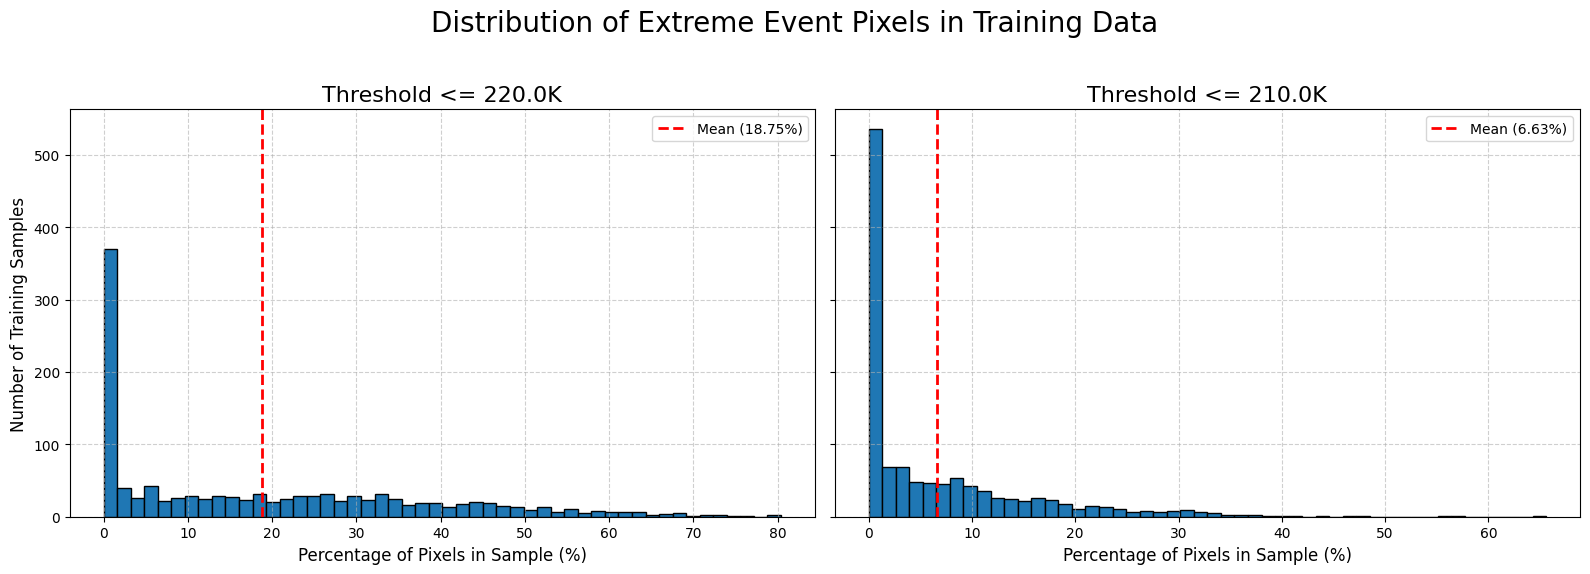

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import gc

# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_analysis_results'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
THRESHOLDS_TO_ANALYZE = [220.0, 210.0] # Kelvin

# --- MAIN ANALYSIS SCRIPT ---
def analyze_data_distribution():
    """
    Iterates through the entire training dataset to analyze the distribution
    of rare event pixels.
    """
    print("--- Starting Training Data Distribution Analysis ---")

    # --- Load the training dataset ---
    # We don't need predictors, so we can modify the dataset logic slightly
    # for speed if necessary, but for now we'll use the existing class.
    train_dataset = MultiVariableARDataset(DATA_DIR, 'train')
    stats = train_dataset.stats
    mean, std = stats['target_mean'], stats['target_std'] + 1e-8

    pixel_percentages = {thresh: [] for thresh in THRESHOLDS_TO_ANALYZE}
    total_pixels_per_sample = 0

    print(f"Analyzing {len(train_dataset)} training samples...")
    pbar = tqdm(train_dataset, desc="Processing samples")
    for _, target_norm, _ in pbar:

        ground_truth_k = target_norm.numpy().squeeze() * std + mean

        if total_pixels_per_sample == 0:
            total_pixels_per_sample = ground_truth_k.size

        for thresh in THRESHOLDS_TO_ANALYZE:
            cold_pixels = (ground_truth_k <= thresh).sum()
            percentage = (cold_pixels / total_pixels_per_sample) * 100
            pixel_percentages[thresh].append(percentage)

    print("\n" + "="*80)
    print("                 Training Data Distribution Summary")
    print("="*80)

    for thresh in THRESHOLDS_TO_ANALYZE:
        percentages = np.array(pixel_percentages[thresh])
        print(f"\n--- Analysis for Threshold <= {thresh}K ---")
        print(f"  - Mean Percentage Across All Samples: {percentages.mean():.2f}%")
        print(f"  - Median Percentage Across All Samples: {np.median(percentages):.2f}%")
        print(f"  - Max Percentage in a Single Sample: {percentages.max():.2f}%")
        print(f"  - Samples with ZERO relevant pixels: {np.sum(percentages == 0)} / {len(percentages)} ({ (np.sum(percentages == 0)/len(percentages))*100:.1f}%)")
        print(f"  - Samples with < 1% relevant pixels: {np.sum(percentages < 1)} / {len(percentages)} ({ (np.sum(percentages < 1)/len(percentages))*100:.1f}%)")

    # --- Visualization ---
    fig, axes = plt.subplots(1, len(THRESHOLDS_TO_ANALYZE), figsize=(16, 6), sharey=True)
    fig.suptitle('Distribution of Extreme Event Pixels in Training Data', fontsize=20)

    for i, thresh in enumerate(THRESHOLDS_TO_ANALYZE):
        ax = axes[i]
        percentages = pixel_percentages[thresh]
        ax.hist(percentages, bins=50, range=(0, max(10, np.max(percentages))), edgecolor='black')
        ax.set_title(f'Threshold <= {thresh}K', fontsize=16)
        ax.set_xlabel('Percentage of Pixels in Sample (%)', fontsize=12)
        if i == 0:
            ax.set_ylabel('Number of Training Samples', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axvline(np.mean(percentages), color='r', linestyle='--', linewidth=2, label=f'Mean ({np.mean(percentages):.2f}%)')
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = OUTPUT_DIR / 'training_data_distribution.png'
    plt.savefig(save_path, dpi=150)
    print(f"\n✅ Distribution plot saved to: {save_path}")

    gc.collect()

if __name__ == '__main__':
    if MultiVariableARDataset is not None:
        analyze_data_distribution()
    else:
        print("Analysis script aborted due to missing dataset class.")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm

# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
MODEL_PATH = PROJECT_PATH / 'hip_eef_direct_model' / 'hip_eef_direct_model.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_final_verification'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Verification Parameters ---
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
VARIABLE_NAMES = ['T500', 'T850', 'RH700', 'W500']
VARIABLE_INDICES = [ALL_VARIABLES.index(v) for v in VARIABLE_NAMES]
INPUT_CHANNELS = len(VARIABLE_INDICES)
THRESHOLD = 220.0 # Kelvin
TARGET_SHAPE = (256, 256) # Enforce a standard evaluation grid

def crop_or_pad_with_mask(arr, target_shape):
    """Center-crops or pads a 2D array to a target shape, returning array and valid mask."""
    h, w = arr.shape
    th, tw = target_shape

    # Create a mask for valid (non-padded) pixels
    valid_mask = np.ones(target_shape, dtype=bool)

    if h == th and w == tw:
        return arr, valid_mask

    # Crop
    start_h = max(0, (h - th) // 2)
    start_w = max(0, (w - tw) // 2)
    end_h = min(h, start_h + th)
    end_w = min(w, start_w + tw)

    cropped = arr[start_h:end_h, start_w:end_w]

    # Pad if necessary
    h_crop, w_crop = cropped.shape
    if h_crop < th or w_crop < tw:
        padded = np.zeros(target_shape, dtype=arr.dtype)
        padded[:h_crop, :w_crop] = cropped
        # Update mask to mark padded regions as invalid
        valid_mask[h_crop:, :] = False
        valid_mask[:, w_crop:] = False
        return padded, valid_mask

    return cropped, valid_mask

# --- ADVANCED METRICS CALCULATION WITH MASK SUPPORT ---
def calculate_verification_metrics_masked(prediction_k, ground_truth_k, valid_mask, threshold):
    """Calculate metrics only on valid (non-padded) pixels."""
    # Apply mask to both arrays
    pred_valid = prediction_k[valid_mask]
    gt_valid = ground_truth_k[valid_mask]

    pred_mask = (pred_valid <= threshold)
    gt_mask = (gt_valid <= threshold)

    hits = np.sum(pred_mask & gt_mask)
    misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask)

    pod = hits / (hits + misses) if (hits + misses) > 0 else 0.0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0.0
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    bias = (hits + false_alarms) / (hits + misses) if (hits + misses) > 0 else 0.0

    return {
        'csi': csi,
        'pod': pod,
        'far': far,
        'bias': bias,
        'predicted_percent': np.mean(pred_mask) * 100,
        'actual_percent': np.mean(gt_mask) * 100
    }

# --- MAIN VERIFICATION SCRIPT ---
def final_verification():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Final Model Verification on {device} ---")
    if not MODEL_PATH.exists():
        print(f"FATAL ERROR: Model file not found at {MODEL_PATH}")
        return

    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    model = HiP_EEF_Direct(n_channels=INPUT_CHANNELS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print(f"Successfully loaded model from {MODEL_PATH}")

    stats = test_dataset.stats
    mean, std = stats['target_mean'], stats['target_std'] + 1e-8
    all_metrics = []

    # Store indices along with metrics
    eventful_indices = []

    # --- Modified loop with mask-based calculation ---
    pbar = tqdm(range(len(test_dataset)), desc="Verifying on Test Set")
    for i in pbar:
        predictor, target_norm, _ = test_dataset[i]
        predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)

        with torch.no_grad():
            final_pred, _, _ = model(predictor_subset)

        # Denormalize at native resolution first
        final_pred_k_native = final_pred.cpu().numpy().squeeze() * std + mean
        ground_truth_k_native = target_norm.numpy().squeeze() * std + mean

        # Standardize both prediction and ground truth to the 256x256 grid WITH MASKS
        final_pred_k, pred_mask = crop_or_pad_with_mask(final_pred_k_native, TARGET_SHAPE)
        ground_truth_k, gt_mask = crop_or_pad_with_mask(ground_truth_k_native, TARGET_SHAPE)

        # Combine masks - only use pixels that are valid in both prediction and ground truth
        combined_mask = pred_mask & gt_mask

        # Calculate metrics only on valid pixels
        metrics = calculate_verification_metrics_masked(final_pred_k, ground_truth_k, combined_mask, THRESHOLD)

        # Apply the 1.0% filter
        if metrics['actual_percent'] > 1.0:
            all_metrics.append(metrics)
            eventful_indices.append(i)

    # --- Aggregate and Print Results ---
    print("\n\n" + "="*60)
    print("      DETAILED VERIFICATION SUMMARY (Events > 1.0%)")
    print("="*60)
    avg_csi = np.mean([m['csi'] for m in all_metrics])
    avg_pod = np.mean([m['pod'] for m in all_metrics])
    avg_far = np.mean([m['far'] for m in all_metrics])
    avg_bias = np.mean([m['bias'] for m in all_metrics])
    print(f"  - Analyzed {len(all_metrics)} eventful cases from the test set.")
    print(f"  - Average CSI:         {avg_csi:.4f}")
    print(f"  - Average POD (Hit Rate): {avg_pod:.4f}")
    print(f"  - Average FAR:         {avg_far:.4f}")
    print(f"  - Average Bias Score:  {avg_bias:.4f}")
    print("="*60)

    if avg_bias > 1.25:
        print("  - Interpretation: Model shows a tendency to OVER-PREDICT.")
    elif avg_bias < 0.8:
        print("  - Interpretation: Model shows a tendency to UNDER-PREDICT.")
    else:
        print("  - Interpretation: Model is well-calibrated (Bias score is close to 1).")

    # --- Bias Scatter Plot ---
    predicted_percents = [m['predicted_percent'] for m in all_metrics]
    actual_percents = [m['actual_percent'] for m in all_metrics]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(actual_percents, predicted_percents, alpha=0.6, edgecolor='k', s=50)
    ax.plot([0, 100], [0, 100], 'r--', label='Perfect Calibration (y=x)')
    ax.set_xlabel('Actual Event Coverage (% of pixels with TBB ≤ 220K)')
    ax.set_ylabel('Predicted Event Coverage (% of pixels with TBB ≤ 220K)')
    ax.set_title('Model Bias Scatter Plot (Valid Pixels Only)')
    ax.grid(True, linestyle='--')
    ax.legend()
    ax.set_xlim(0, max(actual_percents) * 1.1 if actual_percents else 1)
    ax.set_ylim(0, max(predicted_percents) * 1.1 if predicted_percents else 1)

    save_path = OUTPUT_DIR / 'bias_scatter_plot.png'
    plt.savefig(save_path, dpi=150)
    print(f"\n✅ Bias scatter plot saved to: {save_path}")
    plt.close(fig)

    # --- Find and Visualize Best Case ---
    actuals = np.array(actual_percents)
    best_case_metric_idx = np.argmax(actuals)
    original_dataset_idx = eventful_indices[best_case_metric_idx]

    predictor, target_norm, case_name = test_dataset[original_dataset_idx]
    predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)
    with torch.no_grad():
        final_pred, cont_pred, ext_pred = model(predictor_subset)

    final_pred_k = final_pred.cpu().numpy().squeeze() * std + mean
    cont_pred_k = cont_pred.cpu().numpy().squeeze() * std + mean
    ext_pred_k = ext_pred.cpu().numpy().squeeze() * std + mean
    ground_truth_k = target_norm.numpy().squeeze() * std + mean

    # Calculate CSI for visualization (using original arrays, not cropped)
    csi_best_case = calculate_verification_metrics_masked(
        final_pred_k, ground_truth_k,
        np.ones_like(final_pred_k, dtype=bool),
        THRESHOLD
    )['csi']

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(f'Direct Residual Prediction Analysis: {case_name}\nFinal CSI @ {THRESHOLD}K = {csi_best_case:.3f}', fontsize=18)

    vmin, vmax = np.min(ground_truth_k), 255
    axes[0].imshow(ground_truth_k, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[0].set_title('A) Ground Truth')
    axes[1].imshow(cont_pred_k, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[1].set_title('B) Predicted Background')
    ext_vmax = np.abs(ext_pred_k).max()
    axes[2].imshow(ext_pred_k, cmap='coolwarm', vmin=-ext_vmax, vmax=ext_vmax)
    axes[2].set_title('C) Predicted Extreme Residual')
    axes[3].imshow(final_pred_k, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[3].set_title('D) Final Prediction (B + C)')

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    save_path_viz = OUTPUT_DIR / f'visualization_{case_name}.png'
    plt.savefig(save_path_viz, dpi=150, bbox_inches='tight')
    print(f"✅ Visualization for most intense case saved to: {save_path_viz}")
    plt.close(fig)

    gc.collect()

if __name__ == '__main__':
    final_verification()

--- Starting Final Model Verification on cuda ---
Loaded 'test' dataset with 150 samples.
Successfully loaded model from /content/drive/My Drive/AR_Downscaling/hip_eef_direct_model/hip_eef_direct_model.pth


Verifying on Test Set: 100%|██████████| 150/150 [03:47<00:00,  1.52s/it]




      DETAILED VERIFICATION SUMMARY (Events > 1.0%)
  - Analyzed 111 eventful cases from the test set.
  - Average CSI:         0.2096
  - Average POD (Hit Rate): 0.3324
  - Average FAR:         0.5111
  - Average Bias Score:  1.2256
  - Interpretation: Model is well-calibrated (Bias score is close to 1).

✅ Bias scatter plot saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_final_verification/bias_scatter_plot.png
✅ Visualization for most intense case saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_final_verification/visualization_20230807_1200.png


--- Starting Robustness Analysis on cuda ---
Loaded 'test' dataset with 150 samples.
Successfully loaded model from /content/drive/My Drive/AR_Downscaling/hip_eef_final_model/hip_eef_final_model_BETA_1.2.pth
Processing all 150 cases and filtering after grid standardization...


Processing and filtering cases: 100%|██████████| 150/150 [00:15<00:00,  9.97it/s]



  ROBUSTNESS ANALYSIS SUMMARY (> 1.0% after 256x256 standardization)
  - Total cases processed: 150
  - Cases meeting criteria: 111
  - Average CSI on this subset: 0.2729
✅ CSI vs Intensity plot saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_robustness_analysis/csi_vs_intensity.png
✅ ROC curve saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_robustness_analysis/roc_curve.png
✅ Performance diagram saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_robustness_analysis/performance_diagram.png

✅ All individual plots saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_robustness_analysis
Individual files:
  1. CSI vs Intensity: csi_vs_intensity.png
  2. ROC Curve: roc_curve.png
  3. Performance Diagram: performance_diagram.png


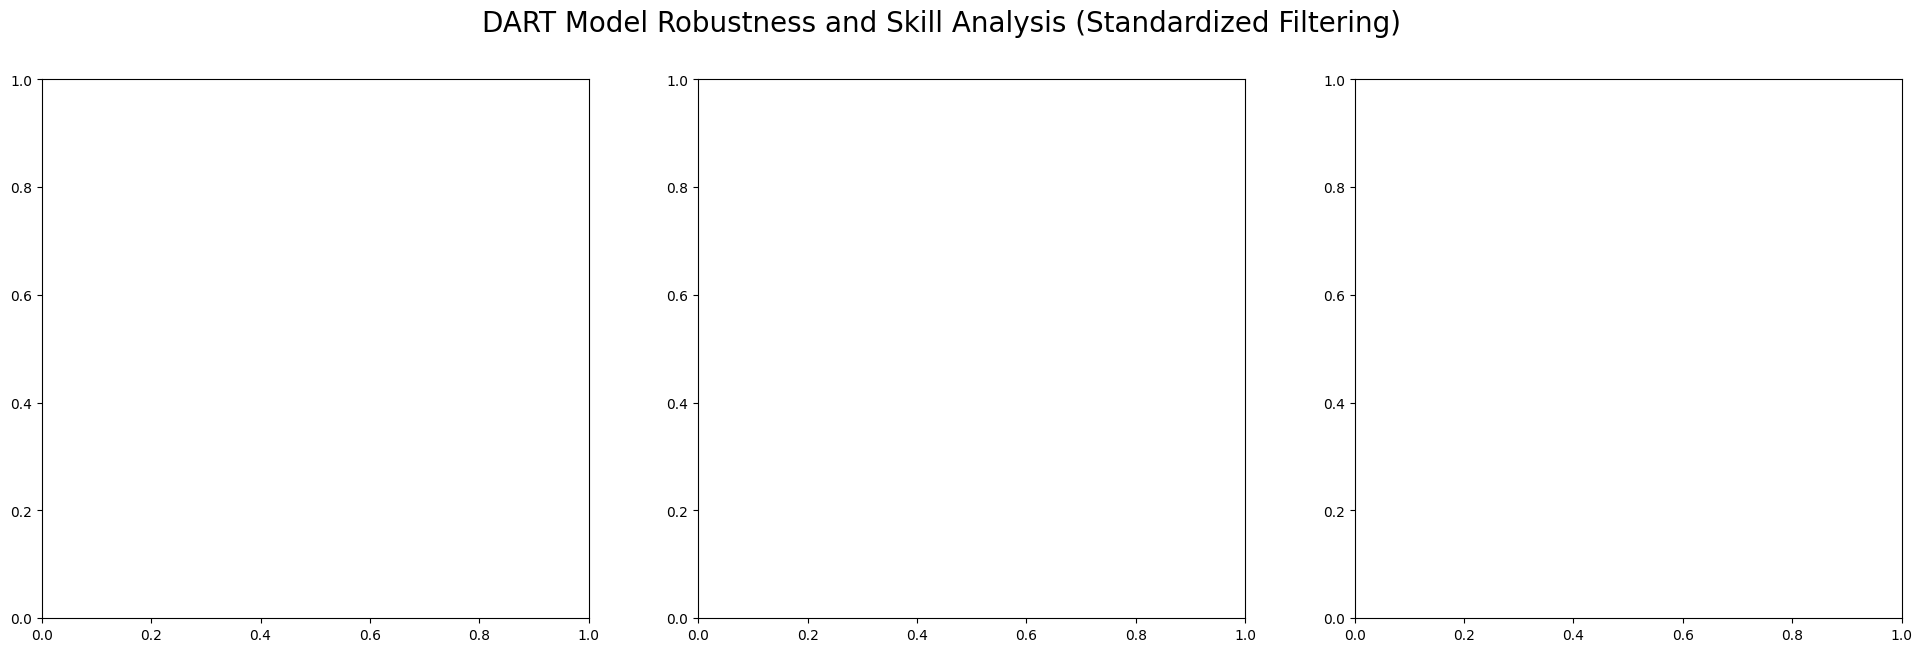

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc


# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
MODEL_PATH = PROJECT_PATH / 'hip_eef_final_model' / 'hip_eef_final_model_BETA_1.2.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_robustness_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
VARIABLE_NAMES = ['T500', 'T850', 'RH700', 'W500']
VARIABLE_INDICES = [ALL_VARIABLES.index(v) for v in VARIABLE_NAMES]
INPUT_CHANNELS = len(VARIABLE_INDICES)
CSI_THRESHOLD = 220.0
FILTER_THRESHOLD_PERCENT = 1.0 # The threshold you requested
TARGET_SHAPE = (256, 256) # Enforce a standard evaluation grid

def crop_or_pad_with_mask(arr, target_shape):
    """Center-crops or pads a 2D array to a target shape, returning array and valid mask."""
    h, w = arr.shape
    th, tw = target_shape

    # Create a mask for valid (non-padded) pixels
    valid_mask = np.ones(target_shape, dtype=bool)

    if h == th and w == tw:
        return arr, valid_mask

    # Crop
    start_h = max(0, (h - th) // 2)
    start_w = max(0, (w - tw) // 2)
    end_h = min(h, start_h + th)
    end_w = min(w, start_w + tw)

    cropped = arr[start_h:end_h, start_w:end_w]

    # Pad if necessary
    h_crop, w_crop = cropped.shape
    if h_crop < th or w_crop < tw:
        padded = np.zeros(target_shape, dtype=arr.dtype)
        padded[:h_crop, :w_crop] = cropped
        # Update mask to mark padded regions as invalid
        valid_mask[h_crop:, :] = False
        valid_mask[:, w_crop:] = False
        return padded, valid_mask

    return cropped, valid_mask

# --- METRICS & PLOTTING FUNCTIONS ---
def calculate_metrics_masked(pred_k, gt_k, valid_mask, threshold):
    """Calculate metrics only on valid (non-padded) pixels."""
    # Apply mask to both arrays
    pred_valid = pred_k[valid_mask]
    gt_valid = gt_k[valid_mask]

    pred_mask = (pred_valid <= threshold)
    gt_mask = (gt_valid <= threshold)

    hits = np.sum(pred_mask & gt_mask)
    misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask)
    correct_negatives = np.sum(~pred_mask & ~gt_mask)

    pod = hits / (hits + misses) if (hits + misses) > 0 else 0.0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0.0
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0

    return {
        'csi': csi,
        'pod': pod,
        'far': far,
        'actual_percent': np.mean(gt_mask) * 100
    }

def plot_performance_diagram(pods, fars, ax):
    """Creates a meteorological performance diagram."""
    success_ratios = 1 - np.array(fars)
    ax.scatter(success_ratios, pods, alpha=0.7, edgecolor='k', s=50, label='Model Performance')

    # Bias and CSI contours
    bias_levels = [0.2, 0.5, 1, 1.5, 2, 5]
    csi_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    sr_grid, pod_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    bias_grid = pod_grid / sr_grid
    csi_grid = 1 / (1/sr_grid + 1/pod_grid - 1)

    cb = ax.contour(sr_grid, pod_grid, bias_grid, levels=bias_levels, linestyles='--', colors='gray')
    ax.clabel(cb, fmt='%.1f', inline=True, fontsize=10)
    cc = ax.contour(sr_grid, pod_grid, csi_grid, levels=csi_levels, colors='dimgray')
    ax.clabel(cc, fmt='%.1f', inline=True, fontsize=10)

    ax.set_xlabel('Success Ratio (1 - FAR)', fontsize=12)
    ax.set_ylabel('Probability of Detection (POD / Hit Rate)', fontsize=12)
    ax.set_title('Performance Diagram', fontsize=16)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.grid(True)
    ax.text(0.95, 0.05, 'Bias', transform=ax.transAxes, ha='right', va='bottom', style='italic', color='gray')
    ax.text(0.05, 0.95, 'CSI', transform=ax.transAxes, ha='left', va='top', style='italic', color='dimgray')

# --- MAIN ANALYSIS SCRIPT ---
def robustness_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Robustness Analysis on {device} ---")
    if not MODEL_PATH.exists():
        print(f"FATAL: Model not found at {MODEL_PATH}")
        return

    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    model = HiP_EEF_Direct(n_channels=INPUT_CHANNELS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print(f"Successfully loaded model from {MODEL_PATH}")

    stats = test_dataset.stats
    mean, std = stats['target_mean'], stats['target_std'] + 1e-8

    # --- Apply filtering After standardizing to 256x256 grid ---
    all_metrics = []
    all_gt_flat = []
    all_pred_flat = []
    eventful_indices = []

    print(f"Processing all {len(test_dataset)} cases and filtering after grid standardization...")
    pbar = tqdm(range(len(test_dataset)), desc="Processing and filtering cases")

    for i in pbar:
        predictor, target_norm, case_name = test_dataset[i]
        predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)

        with torch.no_grad():
            final_pred, _, _ = model(predictor_subset)

        # Denormalize at native resolution first
        final_pred_k_native = final_pred.cpu().numpy().squeeze() * std + mean
        gt_k_native = target_norm.numpy().squeeze() * std + mean

        # Standardize to 256x256 grid with masks
        final_pred_k_processed, pred_mask = crop_or_pad_with_mask(final_pred_k_native, TARGET_SHAPE)
        gt_k_processed, gt_mask = crop_or_pad_with_mask(gt_k_native, TARGET_SHAPE)

        # Combine masks - only use pixels that are valid in both
        combined_mask = pred_mask & gt_mask

        # Calculate metrics only on valid pixels
        metrics = calculate_metrics_masked(final_pred_k_processed, gt_k_processed, combined_mask, CSI_THRESHOLD)

        # Apply the filtering based on actual event percentage
        if metrics['actual_percent'] > FILTER_THRESHOLD_PERCENT:
            all_metrics.append(metrics)
            eventful_indices.append(i)

            # For ROC curve - only use valid pixels
            valid_gt = gt_k_processed[combined_mask]
            valid_pred = final_pred_k_processed[combined_mask]

            all_gt_flat.extend((valid_gt <= CSI_THRESHOLD).astype(int))
            # Use -(T-220) so higher values are "more stormy" for ROC
            all_pred_flat.extend(-(valid_pred - CSI_THRESHOLD))

    # --- Print Summary ---
    avg_csi = np.mean([m['csi'] for m in all_metrics])
    print("\n" + "="*80)
    print(f"  ROBUSTNESS ANALYSIS SUMMARY (> {FILTER_THRESHOLD_PERCENT}% after 256x256 standardization)")
    print("="*80)
    print(f"  - Total cases processed: {len(test_dataset)}")
    print(f"  - Cases meeting criteria: {len(all_metrics)}")
    print(f"  - Average CSI on this subset: {avg_csi:.4f}")
    print("="*80)

    # --- Create Plots ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle('DART Model Robustness and Skill Analysis (Standardized Filtering)', fontsize=20)


    # --- Create Individual Plots with Larger Fonts ---
    # Set global font sizes for better readability
    plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16,
                        'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

    # CSI vs. Event Intensity Plot
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    csis = [m['csi'] for m in all_metrics]
    actual_percents = [m['actual_percent'] for m in all_metrics]
    ax1.scatter(actual_percents, csis, alpha=0.7, edgecolor='k', s=80)
    ax1.set_xlabel('Actual Convection Coverage in Sample (%)', fontsize=16)
    ax1.set_ylabel('Critical Success Index (CSI)', fontsize=16)
    ax1.set_title('DART Performance vs. Event Intensity', fontsize=18, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    save_path_1 = OUTPUT_DIR / 'csi_vs_intensity.png'
    plt.savefig(save_path_1, dpi=150, bbox_inches='tight')
    print(f"✅ CSI vs Intensity plot saved to: {save_path_1}")
    plt.close(fig1)

    # ROC Curve Plot
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    if len(all_gt_flat) > 0 and len(all_pred_flat) > 0:
        fpr, tpr, _ = roc_curve(all_gt_flat, all_pred_flat)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=3, label=f'DART (AUC = {roc_auc:.3f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7, label='Random Classifier')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate', fontsize=16)
        ax2.set_ylabel('True Positive Rate (Sensitivity)', fontsize=16)
        ax2.set_title('ROC Curve: Extreme Event Detection Performance', fontsize=18, pad=20)
        ax2.legend(loc="lower right", fontsize=14)
        ax2.grid(True, alpha=0.7)
        ax2.tick_params(axis='both', which='major', labelsize=14)
    else:
        ax2.text(0.5, 0.5, 'Insufficient valid data for ROC analysis',
                ha='center', va='center', transform=ax2.transAxes, fontsize=16)
        ax2.set_title('ROC Curve: Insufficient Data', fontsize=18)
    plt.tight_layout()
    save_path_2 = OUTPUT_DIR / 'roc_curve.png'
    plt.savefig(save_path_2, dpi=150, bbox_inches='tight')
    print(f"✅ ROC curve saved to: {save_path_2}")
    plt.close(fig2)

    # Performance Diagram Plot
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    pods = [m['pod'] for m in all_metrics]
    fars = [m['far'] for m in all_metrics]

    # Enhanced performance diagram function
    success_ratios = 1 - np.array(fars)
    ax3.scatter(success_ratios, pods, alpha=0.8, edgecolor='k', s=80, color='steelblue',
              label='Model Performance Points')

    # Bias and CSI contours with better styling
    bias_levels = [0.2, 0.5, 1, 1.5, 2, 5]
    csi_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    sr_grid, pod_grid = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
    bias_grid = pod_grid / sr_grid
    csi_grid = 1 / (1/sr_grid + 1/pod_grid - 1)

    # Plot contours with better visibility
    cb = ax3.contour(sr_grid, pod_grid, bias_grid, levels=bias_levels,
                    linestyles='--', colors='gray', alpha=0.6, linewidths=1.5)
    ax3.clabel(cb, fmt='%.1f', inline=True, fontsize=12)

    cc = ax3.contour(sr_grid, pod_grid, csi_grid, levels=csi_levels,
                    colors='dimgray', alpha=0.8, linewidths=1.5)
    ax3.clabel(cc, fmt='%.1f', inline=True, fontsize=12)

    ax3.set_xlabel('Success Ratio (1 - False Alarm Rate)', fontsize=16)
    ax3.set_ylabel('Probability of Detection (Hit Rate)', fontsize=16)
    ax3.set_title('Performance Diagram: DART Event Prediction', fontsize=18, pad=20)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.grid(True, alpha=0.5)
    ax3.tick_params(axis='both', which='major', labelsize=14)

    # Add legend and annotations
    ax3.legend(loc='lower left', fontsize=14)
    ax3.text(0.95, 0.05, 'Bias Lines', transform=ax3.transAxes, ha='right', va='bottom',
            style='italic', color='gray', fontsize=12)
    ax3.text(0.05, 0.95, 'CSI Lines', transform=ax3.transAxes, ha='left', va='top',
            style='italic', color='dimgray', fontsize=12)

    plt.tight_layout()
    save_path_3 = OUTPUT_DIR / 'performance_diagram.png'
    plt.savefig(save_path_3, dpi=150, bbox_inches='tight')
    print(f"✅ Performance diagram saved to: {save_path_3}")
    plt.close(fig3)

    # Reset matplotlib parameters to default
    plt.rcParams.update(plt.rcParamsDefault)

    print(f"\n✅ All individual plots saved to: {OUTPUT_DIR}")
    print("Individual files:")
    print(f"  1. CSI vs Intensity: {save_path_1.name}")
    print(f"  2. ROC Curve: {save_path_2.name}")
    print(f"  3. Performance Diagram: {save_path_3.name}")

    gc.collect()

if __name__ == '__main__':
    if MultiVariableARDataset is not None:
        robustness_analysis()
    else:
        print("Analysis script aborted due to missing dataset class.")

--- Starting Comprehensive Skill Analysis on cuda ---
✅ Loaded HiP-EEF model from /content/drive/My Drive/AR_Downscaling/hip_eef_direct_model/hip_eef_direct_model.pth
✅ Loaded Random Forest model
✅ Loaded MOS model
Loaded 'test' dataset with 150 samples.

Found 111 cases with >1.0% storm coverage on the standard (256, 256) grid.


Analyzing all models on significant cases:   0%|          | 0/111 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
Analyzing all models on significant cases:   1%|          | 1/111 [00:05<10:28,  5.72s/it][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
Analyzing all models on significant cases:   2%|▏         | 2/111 [00:11<10:27,  5.76s/it][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
Analyzing all models on significant cases:   3%|▎         | 3/111 [00:17<10:17,  5.72s/it][Pa


                           FINAL COMPREHENSIVE SKILL SCORE SUMMARY
Metric     | HiP-EEF Model        | Random Forest        | MOS                  | Bicubic Baseline    
--------------------------------------------------------------------------------
HSS        | 0.1531 +/- 0.2061 | 0.0000 +/- 0.0000 | 0.0000 +/- 0.0000 | 0.0046 +/- 0.0562 | 
CSI        | 0.2096 +/- 0.2053 | 0.0000 +/- 0.0000 | 0.0000 +/- 0.0000 | 0.0128 +/- 0.0620 | 

✅ Final skill comparison plot saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_final_comprehensive_analysis/final_skill_comparison.png


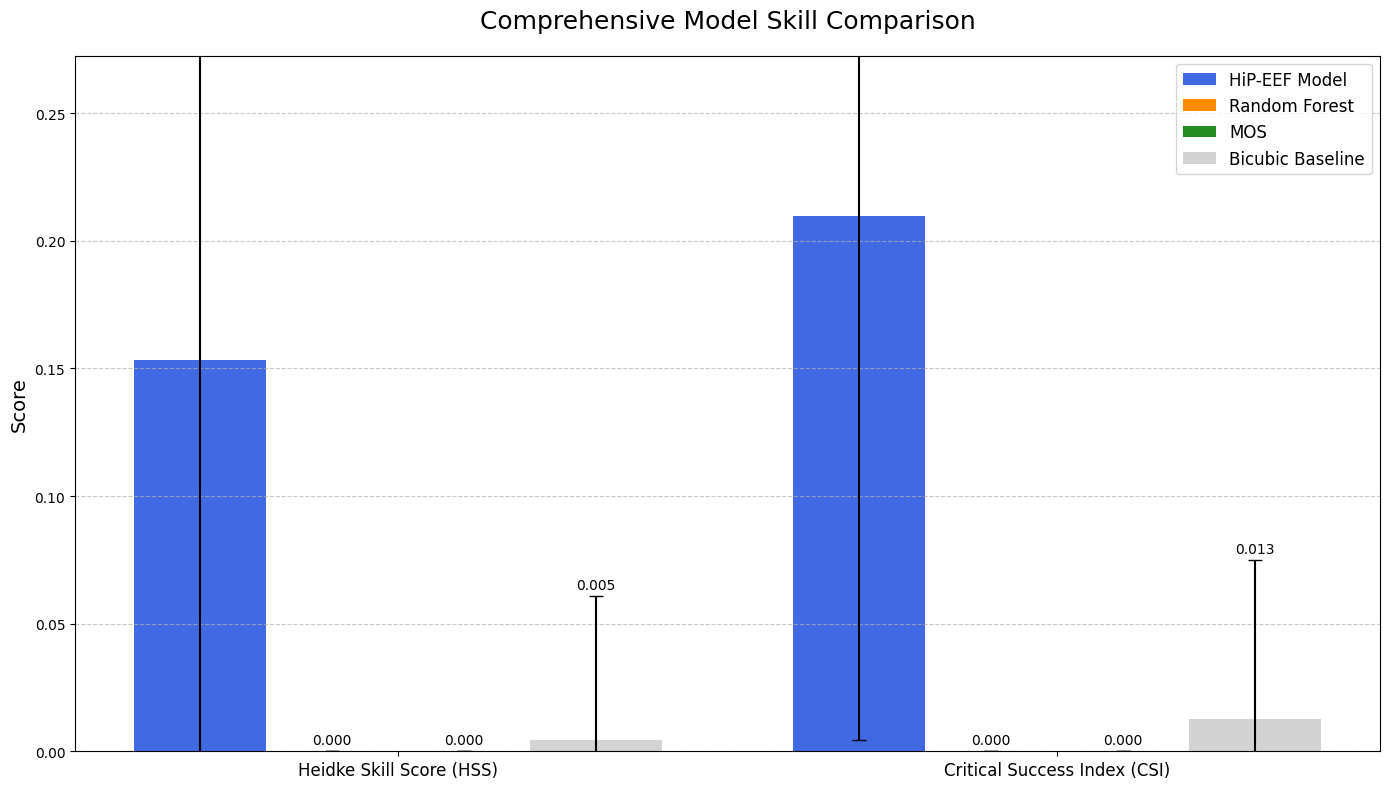

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm
import joblib
from scipy.ndimage import zoom, uniform_filter

# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
MODEL_PATH = PROJECT_PATH / 'hip_eef_direct_model' / 'hip_eef_direct_model.pth'
BASELINE_MODEL_DIR = PROJECT_PATH / 'publication_experiments'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_final_comprehensive_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
TARGET_SHAPE = (256, 256) # Enforce a standard evaluation grid
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
HIP_EEF_VARIABLES = ['T500', 'T850', 'RH700', 'W500']
HIP_EEF_INDICES = [ALL_VARIABLES.index(v) for v in HIP_EEF_VARIABLES]
INPUT_CHANNELS_HIP_EEF = len(HIP_EEF_INDICES)
THRESHOLD = 220.0
FILTER_THRESHOLD_PERCENT = 1.0

# --- METRICS & UTILITY FUNCTIONS ---

def crop_or_pad(arr, target_shape):
    """Center-crops or pads a 2D array to a target shape."""
    h, w = arr.shape
    th, tw = target_shape
    if h == th and w == tw:
        return arr

    # Crop
    start_h = max(0, (h - th) // 2)
    start_w = max(0, (w - tw) // 2)
    cropped = arr[start_h : start_h + th, start_w : start_w + tw]

    # Pad if necessary (if original was smaller than target)
    h, w = cropped.shape
    if h < th or w < tw:
        padded = np.full(target_shape, np.nan, dtype=arr.dtype) # Use NaN for padding
        padded[:h, :w] = cropped
        return padded
    return cropped

def get_contingency_table(pred_k, gt_k, threshold):
    pred_mask = (pred_k <= threshold); gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask); misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask); correct_negatives = np.sum(~pred_mask & ~gt_mask)
    return hits, misses, false_alarms, correct_negatives

def calculate_heidke_skill_score(h, m, fa, cn):
    num = 2 * (h * cn - fa * m); den = (h + m) * (m + cn) + (h + fa) * (fa + cn)
    return num / den if den > 0 else 0.0

def extract_neighborhood_features(X_interp, window_size=5):
    # ... (This function is unchanged)
    num_samples, num_channels, h, w = X_interp.shape
    X_pixel_major = X_interp.transpose(0, 2, 3, 1).reshape(-1, num_channels)
    features = np.zeros((X_pixel_major.shape[0], num_channels * 3), dtype=np.float32)
    features[:, :num_channels] = X_pixel_major
    for c in range(num_channels):
        local_mean = uniform_filter(X_interp[:, c], size=window_size)
        local_sq_mean = uniform_filter(X_interp[:, c]**2, size=window_size)
        local_std = np.sqrt(np.maximum(local_sq_mean - local_mean**2, 0))
        features[:, num_channels + c] = local_mean.flatten()
        features[:, (2 * num_channels) + c] = local_std.flatten()
    return features


# --- MAIN ANALYSIS SCRIPT ---

def comprehensive_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Comprehensive Skill Analysis on {device} ---")

    # --- Load All Models ---
    hip_eef_model = HiP_EEF_Direct(n_channels=INPUT_CHANNELS_HIP_EEF).to(device)
    hip_eef_model.load_state_dict(torch.load(MODEL_PATH, map_location=device)); hip_eef_model.eval()
    print(f"✅ Loaded HiP-EEF model from {MODEL_PATH}")
    rf_model = joblib.load(BASELINE_MODEL_DIR / 'strong_baseline_rf' / 'strong_baseline_rf.joblib')
    print(f"✅ Loaded Random Forest model")
    mos_model_grid = joblib.load(BASELINE_MODEL_DIR / 'operational_baseline_mos' / 'mos_model_grid.joblib')
    print(f"✅ Loaded MOS model")

    # --- Load and Filter Data ---
    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    stats = test_dataset.stats; mean, std = stats['target_mean'], stats['target_std'] + 1e-8

    filtered_indices = [ i for i in range(len(test_dataset)) if np.mean(crop_or_pad(test_dataset[i][1].numpy().squeeze(), TARGET_SHAPE) * std + mean <= THRESHOLD) * 100 > FILTER_THRESHOLD_PERCENT]
    print(f"\nFound {len(filtered_indices)} cases with >{FILTER_THRESHOLD_PERCENT}% storm coverage on the standard {TARGET_SHAPE} grid.")

    scores = { 'hip_eef': {'hss': [], 'csi': []}, 'rf': {'hss': [], 'csi': []}, 'mos': {'hss': [], 'csi': []}, 'bicubic': {'hss': [], 'csi': []} }

    pbar = tqdm(filtered_indices, desc="Analyzing all models on significant cases")
    for i in pbar:
        predictor, target_norm, _ = test_dataset[i]
        gt_k_unprocessed = target_norm.numpy().squeeze() * std + mean
        gt_k = crop_or_pad(gt_k_unprocessed, TARGET_SHAPE)

        # --- HiP-EEF Forecast ---
        predictor_subset = predictor[HIP_EEF_INDICES, :, :].unsqueeze(0).to(device)
        with torch.no_grad():
            final_pred_norm, _, _ = hip_eef_model(predictor_subset)
        hip_eef_pred_k_unprocessed = final_pred_norm.cpu().numpy().squeeze() * std + mean
        hip_eef_pred_k = crop_or_pad(hip_eef_pred_k_unprocessed, TARGET_SHAPE)

        # --- Prepare Interpolated Inputs for Baselines ---
        coarse_input_torch = predictor.unsqueeze(0)
        interp_all_vars_norm = F.interpolate(coarse_input_torch, size=TARGET_SHAPE, mode='bicubic', align_corners=False)

        # --- RF Forecast ---
        rf_features = extract_neighborhood_features(interp_all_vars_norm.numpy())
        rf_pred_flat = rf_model.predict(rf_features)
        rf_pred_k = (rf_pred_flat.reshape(TARGET_SHAPE) * std + mean)

        # --- MOS Forecast ---
        mos_input_reshaped = interp_all_vars_norm.numpy().squeeze().transpose(1, 2, 0).reshape(-1, 5)
        mos_pred_flat = np.zeros(mos_input_reshaped.shape[0])
        for pix_idx in range(TARGET_SHAPE[0] * TARGET_SHAPE[1]):
            row, col = pix_idx // TARGET_SHAPE[1], pix_idx % TARGET_SHAPE[1]
            mos_pred_flat[pix_idx] = mos_model_grid[row, col].predict(mos_input_reshaped[pix_idx].reshape(1, -1))[0]
        mos_pred_k = (mos_pred_flat.reshape(TARGET_SHAPE) * std + mean)

        # --- Bicubic Baseline Forecast ---
        bicubic_pred_k = interp_all_vars_norm.numpy().squeeze()[ALL_VARIABLES.index('T500')] * std + mean

        # --- Calculate and Store Metrics for All Models ---
        all_preds = {'hip_eef': hip_eef_pred_k, 'rf': rf_pred_k, 'mos': mos_pred_k, 'bicubic': bicubic_pred_k}
        for name, pred in all_preds.items():
            h, m, fa, cn = get_contingency_table(pred, gt_k, THRESHOLD)
            scores[name]['hss'].append(calculate_heidke_skill_score(h, m, fa, cn))
            scores[name]['csi'].append(h / (h + m + fa) if (h + m + fa) > 0 else 0.0)

    # --- Print & Plot Final Results ---
    print("\n" + "="*80); print("                           FINAL COMPREHENSIVE SKILL SCORE SUMMARY"); print("="*80)
    print(f"{'Metric':<10} | {'HiP-EEF Model':<20} | {'Random Forest':<20} | {'MOS':<20} | {'Bicubic Baseline':<20}"); print("-"*80)
    for metric in ['hss', 'csi']:
        line = f"{metric.upper():<10} | ";
        for model in ['hip_eef', 'rf', 'mos', 'bicubic']:
            mean_score, std_score = np.mean(scores[model][metric]), np.std(scores[model][metric])
            line += f"{mean_score:.4f} +/- {std_score:.4f} | "
        print(line)
    print("="*80)

    # Bar Chart
    labels = ['Heidke Skill Score (HSS)', 'Critical Success Index (CSI)']; model_names = ['HiP-EEF Model', 'Random Forest', 'MOS', 'Bicubic Baseline']
    means = {name: [np.mean(scores[name]['hss']), np.mean(scores[name]['csi'])] for name in scores}; stds = {name: [np.std(scores[name]['hss']), np.std(scores[name]['csi'])] for name in scores}
    x = np.arange(len(labels)); width = 0.2; fig, ax = plt.subplots(figsize=(14, 8)); colors = ['royalblue', 'darkorange', 'forestgreen', 'lightgray']
    for i, name in enumerate(scores.keys()):
        rects = ax.bar(x + (i - 1.5) * width, means[list(scores.keys())[i]], width, yerr=stds[list(scores.keys())[i]], label=model_names[i], capsize=5, color=colors[i])
        ax.bar_label(rects, padding=3, fmt='%.3f')
    ax.set_ylabel('Score', fontsize=14); ax.set_title('Comprehensive Model Skill Comparison', fontsize=18, pad=20)
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=12); ax.legend(fontsize=12); ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(means['hip_eef']) * 1.3 if means['hip_eef'][0] > 0 else 0.1)
    plt.tight_layout()
    save_path = OUTPUT_DIR / 'final_skill_comparison.png'; plt.savefig(save_path, dpi=150)
    print(f"\n✅ Final skill comparison plot saved to: {save_path}")

if __name__ == '__main__':
    comprehensive_analysis()



--- Starting Final Case Study Analysis on cuda ---
Loaded 'test' dataset with 150 samples.
Successfully loaded model from /content/drive/My Drive/AR_Downscaling/hip_eef_direct_model/hip_eef_direct_model.pth
Searching for best 'small, intense storm' case...


Scanning test set: 100%|██████████| 150/150 [01:50<00:00,  1.35it/s]


Found best small case: Index 119 (CSI: 0.625, Size: 9.55%)

✅ Final case study visualization saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_case_study/final_case_study.png


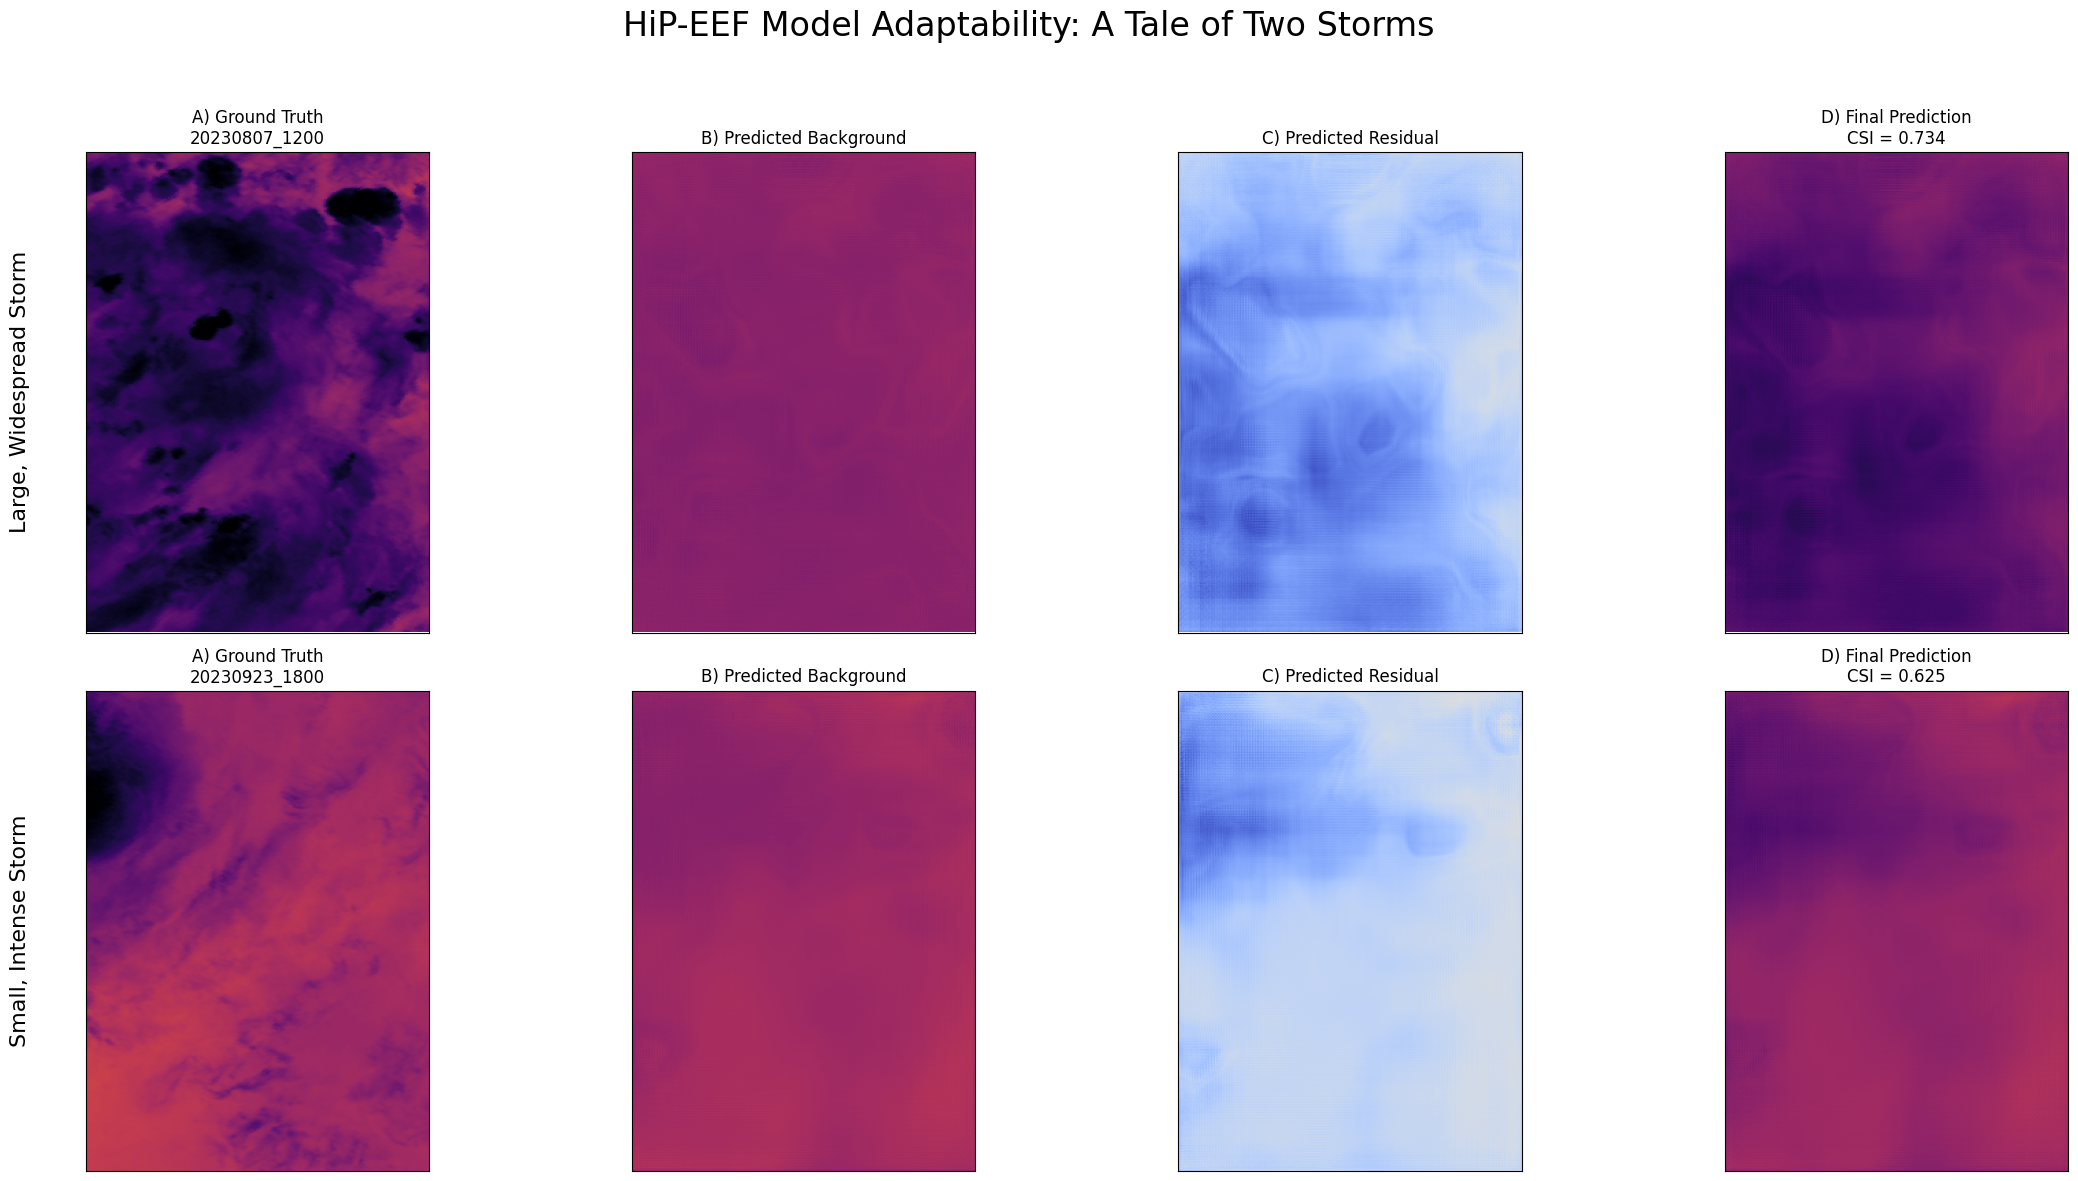

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm


# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
MODEL_PATH = PROJECT_PATH / 'hip_eef_direct_model' / 'hip_eef_direct_model.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_case_study'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
VARIABLE_NAMES = ['T500', 'T850', 'RH700', 'W500']
VARIABLE_INDICES = [ALL_VARIABLES.index(v) for v in VARIABLE_NAMES]
INPUT_CHANNELS = len(VARIABLE_INDICES)
THRESHOLD = 220.0

# --- CASE FINDING & VISUALIZATION LOGIC ---

def calculate_csi(pred_k, gt_k, threshold):
    pred_mask = (pred_k <= threshold); gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask); misses = np.sum(~pred_mask & gt_mask); false_alarms = np.sum(pred_mask & ~gt_mask)
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    return csi

def find_best_small_case(dataset, model, stats, device):
    """Finds a high-performing case with a small storm footprint."""
    print("Searching for best 'small, intense storm' case...")
    best_case = {'idx': -1, 'csi': -1, 'percent': 100}

    pbar = tqdm(range(len(dataset)), desc="Scanning test set")
    for i in pbar:
        predictor, target_norm, _ = dataset[i]
        gt_k = target_norm.numpy().squeeze() * (stats['target_std'] + 1e-8) + stats['target_mean']

        actual_percent = np.mean(gt_k <= THRESHOLD) * 100

        # Criteria: storm covers between 1% and 10% of the area
        if 1.0 < actual_percent < 10.0:
            predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)
            with torch.no_grad():
                final_pred, _, _ = model(predictor_subset)

            final_pred_k = final_pred.cpu().numpy().squeeze() * (stats['target_std'] + 1e-8) + stats['target_mean']
            csi = calculate_csi(final_pred_k, gt_k, THRESHOLD)

            if csi > best_case['csi']:
                best_case = {'idx': i, 'csi': csi, 'percent': actual_percent}

    print(f"Found best small case: Index {best_case['idx']} (CSI: {best_case['csi']:.3f}, Size: {best_case['percent']:.2f}%)")
    return best_case['idx']


def plot_case(ax_row, case_data, model, stats, device):
    """Generates the 4-panel plot for a single case."""
    predictor, target_norm, case_name = case_data
    predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)

    with torch.no_grad():
        final_pred, cont_pred, ext_pred = model(predictor_subset)

    mean, std = stats['target_mean'], stats['target_std'] + 1e-8
    gt_k = target_norm.numpy().squeeze() * std + mean
    final_pred_k = final_pred.cpu().numpy().squeeze() * std + mean
    cont_pred_k = cont_pred.cpu().numpy().squeeze() * std + mean
    ext_pred_k = (ext_pred.cpu().numpy().squeeze() * std) # Residual is already relative

    csi = calculate_csi(final_pred_k, gt_k, THRESHOLD)

    vmin, vmax = 200, 270

    ax_row[0].imshow(gt_k, cmap='inferno', vmin=vmin, vmax=vmax); ax_row[0].set_title(f'A) Ground Truth\n{case_name}')
    ax_row[1].imshow(cont_pred_k, cmap='inferno', vmin=vmin, vmax=vmax); ax_row[1].set_title('B) Predicted Background')
    ext_vmax = np.abs(ext_pred_k).max(); ax_row[2].imshow(ext_pred_k, cmap='coolwarm', vmin=-ext_vmax, vmax=ext_vmax); ax_row[2].set_title('C) Predicted Residual')
    ax_row[3].imshow(final_pred_k, cmap='inferno', vmin=vmin, vmax=vmax); ax_row[3].set_title(f'D) Final Prediction\nCSI = {csi:.3f}')

    for ax in ax_row: ax.set_xticks([]); ax.set_yticks([])


# --- MAIN ANALYSIS SCRIPT ---
def case_study_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Final Case Study Analysis on {device} ---")
    if not MODEL_PATH.exists(): print(f"FATAL: Model not found at {MODEL_PATH}"); return

    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    model = HiP_EEF_Direct(n_channels=INPUT_CHANNELS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device)); model.eval()
    print(f"Successfully loaded model from {MODEL_PATH}")
    stats = test_dataset.stats

    # --- Find Cases ---
    case_names_list = [f.stem.replace('_predictor', '') for f in test_dataset.predictor_files]
    large_case_idx = case_names_list.index('20230807_1200')
    small_case_idx = find_best_small_case(test_dataset, model, stats, device)

    # --- Create the 8-Panel Plot ---
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle('HiP-EEF Model Adaptability: A Tale of Two Storms', fontsize=24, y=0.98)

    # Row 1: Large, Widespread Storm
    plot_case(axes[0], test_dataset[large_case_idx], model, stats, device)
    axes[0, 0].set_ylabel('Large, Widespread Storm', fontsize=16, labelpad=40)

    # Row 2: Small, Intense Storm
    plot_case(axes[1], test_dataset[small_case_idx], model, stats, device)
    axes[1, 0].set_ylabel('Small, Intense Storm', fontsize=16, labelpad=40)

    plt.tight_layout(rect=[0.03, 0, 1, 0.95])
    save_path = OUTPUT_DIR / 'final_case_study.png'
    plt.savefig(save_path, dpi=150)
    print(f"\n✅ Final case study visualization saved to: {save_path}")

    gc.collect()

if __name__ == '__main__':
    if MultiVariableARDataset is not None:
        case_study_analysis()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from matplotlib.colors import ListedColormap


# --- 1. CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
MODEL_PATH = PROJECT_PATH / 'hip_eef_final_model' / 'hip_eef_final_model_BETA_1.2.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_contingency_maps_beta'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
VARIABLE_NAMES = ['T500', 'T850', 'RH700', 'W500']
VARIABLE_INDICES = [ALL_VARIABLES.index(v) for v in VARIABLE_NAMES]
INPUT_CHANNELS = len(VARIABLE_INDICES)
THRESHOLD = 220.0

# --- CASE FINDING & VISUALIZATION LOGIC ---

def create_contingency_map(pred_k, gt_k, threshold):
    """Creates a map of hits, misses, false alarms, and correct negatives."""
    pred_mask = (pred_k <= threshold)
    gt_mask = (gt_k <= threshold)

    # 0: Correct Negative, 1: False Alarm, 2: Miss, 3: Hit
    contingency = np.zeros(gt_k.shape, dtype=int)
    contingency[(~pred_mask) & (~gt_mask)] = 0 # Correct Negative
    contingency[(pred_mask) & (~gt_mask)] = 1  # False Alarm
    contingency[(~pred_mask) & (gt_mask)] = 2  # Miss
    contingency[(pred_mask) & (gt_mask)] = 3   # Hit
    return contingency

def find_best_small_case_idx(dataset, model, stats, device):
    """Finds the index of the best-performing small storm case."""
    best_case = {'idx': -1, 'csi': -1, 'name': '', 'percent': 0}

    for i in range(len(dataset)):
        _, target_norm, case_name = dataset[i]
        gt_k = target_norm.numpy().squeeze() * (stats['target_std'] + 1e-8) + stats['target_mean']
        actual_percent = np.mean(gt_k <= THRESHOLD) * 100

        # Look for small but significant storms (1-10% coverage)
        if 1.0 < actual_percent < 10.0:
            predictor, _, _ = dataset[i]
            predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)
            with torch.no_grad():
                final_pred, _, _ = model(predictor_subset)
            final_pred_k = final_pred.cpu().numpy().squeeze() * (stats['target_std'] + 1e-8) + stats['target_mean']

            pred_mask = (final_pred_k <= THRESHOLD)
            gt_mask = (gt_k <= THRESHOLD)
            hits = np.sum(pred_mask & gt_mask)
            misses = np.sum(~pred_mask & gt_mask)
            false_alarms = np.sum(pred_mask & ~gt_mask)
            csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0

            if csi > best_case['csi']:
                best_case = {'idx': i, 'csi': csi, 'name': case_name, 'percent': actual_percent}

    print(f"Selected best small case: {best_case['name']} (CSI: {best_case['csi']:.3f}, Coverage: {best_case['percent']:.1f}%)")
    return best_case['idx']

def calculate_case_metrics(pred_k, gt_k, threshold):
    """Calculate performance metrics for a case."""
    pred_mask = (pred_k <= threshold)
    gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask)
    misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask)
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    pod = hits / (hits + misses) if (hits + misses) > 0 else 0.0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0.0
    return csi, pod, far

def plot_single_case(case_data, model, stats, device, title_prefix, save_name):
    """Generate a single 3-panel plot for one case."""
    predictor, target_norm, case_name = case_data
    predictor_subset = predictor[VARIABLE_INDICES, :, :].unsqueeze(0).to(device)

    with torch.no_grad():
        final_pred, _, _ = model(predictor_subset)

    mean, std = stats['target_mean'], stats['target_std'] + 1e-8
    gt_k = target_norm.numpy().squeeze() * std + mean
    final_pred_k = final_pred.cpu().numpy().squeeze() * std + mean

    # Calculate metrics
    csi, pod, far = calculate_case_metrics(final_pred_k, gt_k, THRESHOLD)
    actual_percent = np.mean(gt_k <= THRESHOLD) * 100

    # Create the contingency map
    contingency_map = create_contingency_map(final_pred_k, gt_k, THRESHOLD)
    colors = ['#3A3A3A', '#FDB813', '#D62728', '#2CA02C'] # Dark Gray, Yellow, Red, Green
    cmap = ListedColormap(colors)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{title_prefix}: {case_name}\nCSI: {csi:.3f} | POD: {pod:.3f} | FAR: {far:.3f} | Storm Coverage: {actual_percent:.1f}%',
                fontsize=16, y=1.02)

    # Plot panels
    vmin, vmax = 200, 270
    im1 = axes[0].imshow(gt_k, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[0].set_title('Ground Truth', fontsize=14)

    im2 = axes[1].imshow(final_pred_k, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[1].set_title('HiP-EEF Prediction', fontsize=14)

    im3 = axes[2].imshow(contingency_map, cmap=cmap, vmin=0, vmax=3)
    axes[2].set_title('Verification Map', fontsize=14)

    # Add colorbar for temperature plots
    cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
    cbar1.set_label('Brightness Temperature (K)', fontsize=12)
    cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.8)
    cbar2.set_label('Brightness Temperature (K)', fontsize=12)

    # Add legend for contingency map
    patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]
    labels = ['Correct Negative', 'False Alarm', 'Miss', 'Hit']
    axes[2].legend(patches, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10)

    # Remove axis ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    save_path = OUTPUT_DIR / f'{save_name}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✅ {title_prefix} saved to: {save_path}")
    plt.close(fig)

# --- MAIN ANALYSIS SCRIPT ---
def contingency_map_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Contingency Map Analysis on {device} ---")
    if not MODEL_PATH.exists():
        print(f"FATAL: Model not found at {MODEL_PATH}")
        return

    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    model = HiP_EEF_Direct(n_channels=INPUT_CHANNELS).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print(f"Successfully loaded model from {MODEL_PATH}")
    stats = test_dataset.stats

    # Find case indices
    case_names_list = [f.stem.replace('_predictor', '') for f in test_dataset.predictor_files]

    # Two specific Chittagong flooding cases
    case1_idx = case_names_list.index('20230807_1200')
    case2_idx = case_names_list.index('20230807_1800')

    # Best performing small storm case (automatically selected)
    small_case_idx = find_best_small_case_idx(test_dataset, model, stats, device)

    print("\n--- Generating Individual Case Visualizations ---")

    # Generate three separate visualizations
    plot_single_case(test_dataset[case1_idx], model, stats, device,
                    "Chittagong Flooding Event (12:00 UTC)", "chittagong_1200_analysis")

    plot_single_case(test_dataset[case2_idx], model, stats, device,
                    "Chittagong Flooding Event (18:00 UTC)", "chittagong_1800_analysis")

    plot_single_case(test_dataset[small_case_idx], model, stats, device,
                    "Best Small Storm Case", "best_small_storm_analysis")

    print(f"\n✅ All contingency map visualizations saved to: {OUTPUT_DIR}")
    gc.collect()

if __name__ == '__main__':
    if MultiVariableARDataset is not None:
        contingency_map_analysis()
    else:
        print("Analysis script aborted due to missing dataset class.")

--- Starting Contingency Map Analysis on cuda ---
Loaded 'test' dataset with 150 samples.
Successfully loaded model from /content/drive/My Drive/AR_Downscaling/hip_eef_final_model/hip_eef_final_model_BETA_1.2.pth
Selected best small case: 20230923_1800 (CSI: 0.528, Coverage: 9.6%)

--- Generating Individual Case Visualizations ---
✅ Chittagong Flooding Event (12:00 UTC) saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_contingency_maps_beta/chittagong_1200_analysis.png
✅ Chittagong Flooding Event (18:00 UTC) saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_contingency_maps_beta/chittagong_1800_analysis.png
✅ Best Small Storm Case saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_contingency_maps_beta/best_small_storm_analysis.png

✅ All contingency map visualizations saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_contingency_maps_beta


--- Starting Final Comprehensive Skill Analysis on cuda ---
✅ Loaded HiP-EEF model
✅ Loaded Attention U-Net baseline
✅ Loaded Random Forest model
✅ Loaded MOS model
Loaded 'test' dataset with 150 samples.

Found 111 cases for the final gold-standard evaluation cohort.


Analyzing all models on significant cases:   0%|          | 0/111 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
Analyzing all models on significant cases:   1%|          | 1/111 [00:06<12:46,  6.97s/it][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
Analyzing all models on significant cases:   2%|▏         | 2/111 [00:12<11:18,  6.22s/it][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
Analyzing all models on significant cases:   3%|▎         | 3/111 [00:18<10:47,  5.99s/it][Pa


                                                FINAL COMPREHENSIVE SKILL SCORE SUMMARY
Metric     | HiP-EEF Model        | Attention U-Net      | Random Forest        | MOS                  | Bicubic             
-----------------------------------------------------------------------------------------------------------------------------
HSS        | 0.1531 +/- 0.2061 | 0.0834 +/- 0.1192 | 0.0000 +/- 0.0000 | 0.0000 +/- 0.0000 | 0.0046 +/- 0.0562 | 
CSI        | 0.2096 +/- 0.2053 | 0.2795 +/- 0.1993 | 0.0000 +/- 0.0000 | 0.0000 +/- 0.0000 | 0.0128 +/- 0.0620 | 

✅ Final skill comparison plot saved to: /content/drive/My Drive/AR_Downscaling/hip_eef_final_comprehensive_analysis/final_comprehensive_skill_comparison.png


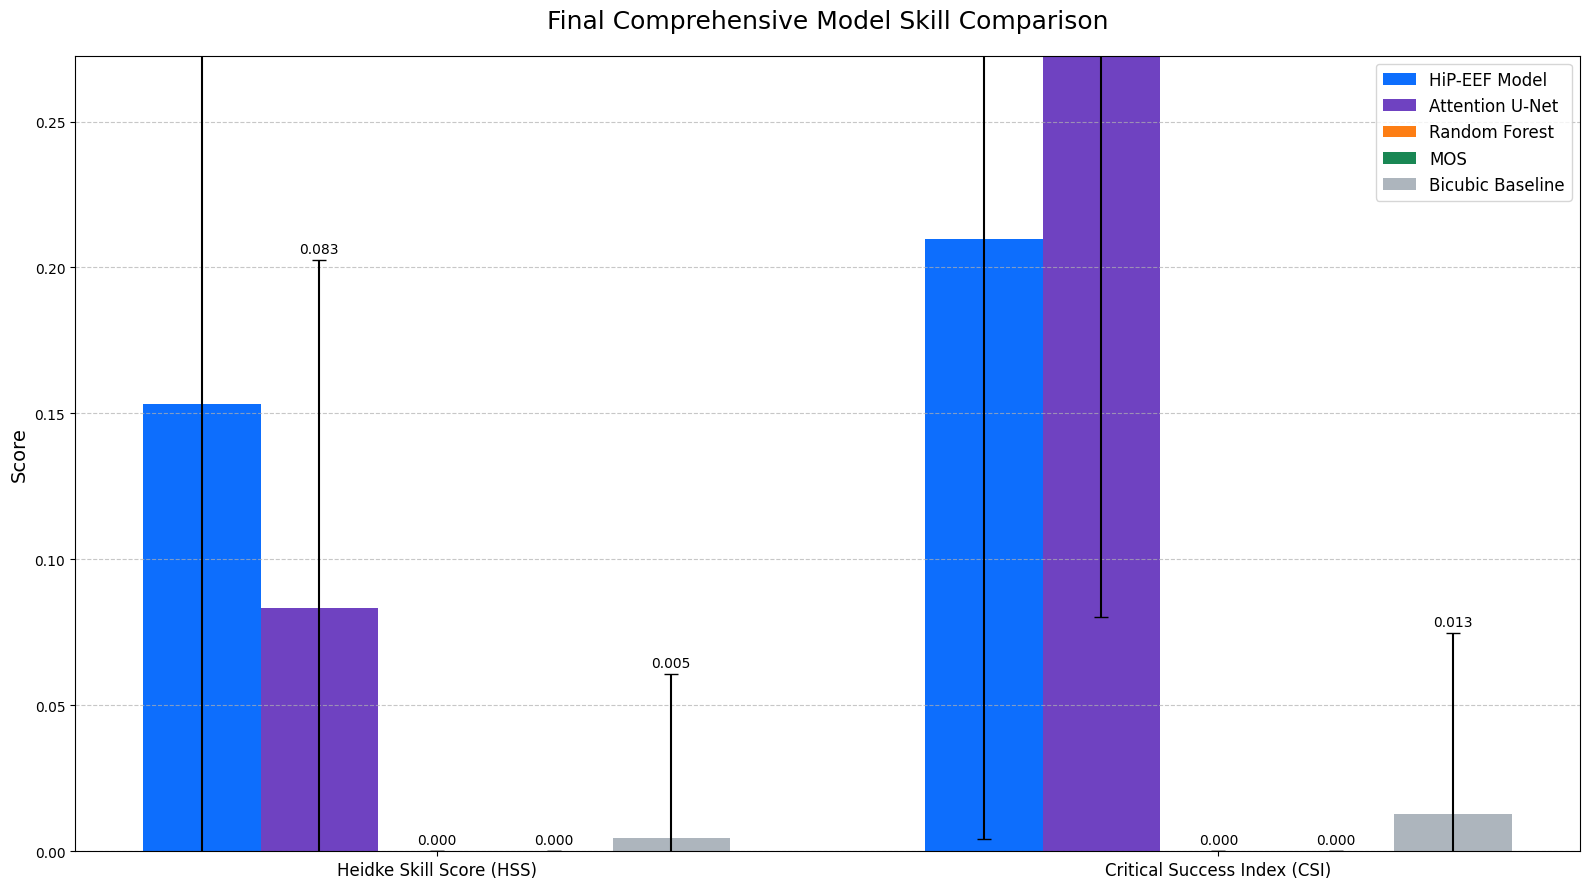

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm
import joblib
from scipy.ndimage import zoom, uniform_filter
import warnings

warnings.filterwarnings('ignore')

# --- SELF-CONTAINED ATTENTION U-NET DEFINITION ---
class SimplifiedUNetAttention(nn.Module):
    """ The attention mechanism for the baseline U-Net. """
    def __init__(self, channels):
        super().__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 16, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 16, channels, 1),
            nn.Sigmoid()
        )
        self.spatial_att = nn.Sequential(
            nn.Conv2d(channels, 1, 7, padding=3),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.channel_att(x) * self.spatial_att(x)

class AttentionUNet(nn.Module):
    """ The strong deep learning baseline model. """
    def __init__(self, input_channels=4, base_channels=64, depth=4):
        super().__init__()
        self.depth = depth
        self.channels = [base_channels * min(2**i, 8) for i in range(depth)]
        self.encoders = nn.ModuleList()
        self.downsamplers = nn.ModuleList()
        in_ch = input_channels
        for i, out_ch in enumerate(self.channels):
            self.encoders.append(self._conv_block(in_ch, out_ch))
            if i < len(self.channels) - 1:
                self.downsamplers.append(nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1))
            in_ch = out_ch

        bn_ch = self.channels[-1]
        self.bottleneck = self._conv_block(self.channels[-1], bn_ch)
        self.attention = SimplifiedUNetAttention(bn_ch)
        self.upsamplers = nn.ModuleList()
        self.decoders = nn.ModuleList()

        for i in range(depth - 1, -1, -1):
            in_ch = bn_ch if i == depth - 1 else self.channels[i+1]
            out_ch = self.channels[i]
            self.upsamplers.append(nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2))
            self.decoders.append(self._conv_block(out_ch * 2, out_ch))

        self.final_conv = nn.Sequential(
            nn.Conv2d(self.channels[0], self.channels[0] // 2, 3, padding=1),
            nn.BatchNorm2d(self.channels[0] // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.channels[0] // 2, 1, 1)
        )

    def _conv_block(self, i, o):
        return nn.Sequential(
            nn.Conv2d(i, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True),
            nn.Conv2d(o, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skips = []
        for i in range(len(self.encoders)):
            x = self.encoders[i](x)
            skips.append(x)
            if i < len(self.downsamplers):
                x = self.downsamplers[i](x)
        x = self.bottleneck(x)
        x = self.attention(x)
        for i, (up, dec) in enumerate(zip(self.upsamplers, self.decoders)):
            x = up(x)
            skip = skips[len(skips) - 1 - i]
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
            x = dec(x)
        return self.final_conv(x)

# --- 1. CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
HIP_EEF_MODEL_PATH = PROJECT_PATH / 'hip_eef_direct_model' / 'hip_eef_direct_model.pth'
ATTN_UNET_MODEL_PATH = PROJECT_PATH / 'publication_experiments' / 'attention_unet_final' / 'attention_unet_final_model.pth'
BASELINE_MODEL_DIR = PROJECT_PATH / 'publication_experiments'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_final_comprehensive_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Analysis Parameters ---
TARGET_SHAPE = (256, 256)
ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
DL_VARIABLES = ['T500', 'T850', 'RH700', 'W500']
DL_INDICES = [ALL_VARIABLES.index(v) for v in DL_VARIABLES]
THRESHOLD = 220.0
FILTER_THRESHOLD_PERCENT = 1.0

# --- 2. UTILITY FUNCTIONS ---
def crop_or_pad(arr, target_shape):
    h, w = arr.shape; th, tw = target_shape
    if h == th and w == tw: return arr
    start_h = max(0, (h - th) // 2); start_w = max(0, (w - tw) // 2)
    cropped = arr[start_h : start_h + th, start_w : start_w + tw]
    h, w = cropped.shape
    if h < th or w < tw:
        padded = np.full(target_shape, np.nan, dtype=arr.dtype); padded[:h, :w] = cropped; return padded
    return cropped

def get_contingency_table(pred_k, gt_k, threshold):
    pred_mask = (pred_k <= threshold); gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask); misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask); correct_negatives = np.sum(~pred_mask & ~gt_mask)
    return hits, misses, false_alarms, correct_negatives

def calculate_heidke_skill_score(h, m, fa, cn):
    num = 2 * (h * cn - fa * m); den = (h + m) * (m + cn) + (h + fa) * (fa + cn)
    return num / den if den > 0 else 0.0

def extract_neighborhood_features(X_interp, window_size=5):
    num_samples, num_channels, h, w = X_interp.shape
    X_pixel_major = X_interp.transpose(0, 2, 3, 1).reshape(-1, num_channels)
    features = np.zeros((X_pixel_major.shape[0], num_channels * 3), dtype=np.float32)
    features[:, :num_channels] = X_pixel_major
    for c in range(num_channels):
        local_mean = uniform_filter(X_interp[:, c], size=window_size)
        local_sq_mean = uniform_filter(X_interp[:, c]**2, size=window_size)
        local_std = np.sqrt(np.maximum(local_sq_mean - local_mean**2, 0))
        features[:, num_channels + c] = local_mean.flatten()
        features[:, (2 * num_channels) + c] = local_std.flatten()
    return features

# --- 3. MAIN ANALYSIS SCRIPT ---
def comprehensive_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Final Comprehensive Skill Analysis on {device} ---")

    # --- Load All Models ---
    hip_eef_model = HiP_EEF_Direct(n_channels=len(DL_INDICES)).to(device)
    hip_eef_model.load_state_dict(torch.load(HIP_EEF_MODEL_PATH, map_location=device)); hip_eef_model.eval()
    print("✅ Loaded HiP-EEF model")

    attn_unet_model = AttentionUNet(input_channels=len(DL_INDICES)).to(device)
    attn_unet_model.load_state_dict(torch.load(ATTN_UNET_MODEL_PATH, map_location=device)); attn_unet_model.eval()
    print("✅ Loaded Attention U-Net baseline")

    rf_model = joblib.load(BASELINE_MODEL_DIR / 'strong_baseline_rf' / 'strong_baseline_rf.joblib')
    print("✅ Loaded Random Forest model")
    mos_model_grid = joblib.load(BASELINE_MODEL_DIR / 'operational_baseline_mos' / 'mos_model_grid.joblib')
    print("✅ Loaded MOS model")

    # --- Load and Filter Data ---
    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    stats = test_dataset.stats; mean, std = stats['target_mean'], stats['target_std'] + 1e-8

    filtered_indices = [i for i in range(len(test_dataset)) if np.mean(crop_or_pad(test_dataset[i][1].numpy().squeeze(), TARGET_SHAPE) * std + mean <= THRESHOLD) * 100 > FILTER_THRESHOLD_PERCENT]
    print(f"\nFound {len(filtered_indices)} cases for the final gold-standard evaluation cohort.")

    scores = {name: {'hss': [], 'csi': []} for name in ['hip_eef', 'attn_unet', 'rf', 'mos', 'bicubic']}
    pbar = tqdm(filtered_indices, desc="Analyzing all models on significant cases")
    for i in pbar:
        predictor, target_norm, _ = test_dataset[i]
        gt_k = crop_or_pad(target_norm.numpy().squeeze() * std + mean, TARGET_SHAPE)

        # --- DL Model Predictions (4-var input) ---
        predictor_4var = predictor[DL_INDICES, :, :].unsqueeze(0).to(device)
        with torch.no_grad():
            hip_eef_pred_norm, _, _ = hip_eef_model(predictor_4var)
            attn_unet_pred_norm = attn_unet_model(predictor_4var)
        hip_eef_pred_k = crop_or_pad(hip_eef_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)
        attn_unet_pred_k = crop_or_pad(attn_unet_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)

        # --- Baseline Predictions (5-var input) ---
        coarse_5var_torch = predictor.unsqueeze(0)
        interp_5var_norm = F.interpolate(coarse_5var_torch, size=TARGET_SHAPE, mode='bicubic', align_corners=False).numpy()

        rf_features = extract_neighborhood_features(interp_5var_norm)
        rf_pred_flat = rf_model.predict(rf_features); rf_pred_k = (rf_pred_flat.reshape(TARGET_SHAPE) * std + mean)

        mos_input_reshaped = interp_5var_norm.squeeze().transpose(1, 2, 0).reshape(-1, 5)
        mos_pred_flat = np.array([mos_model_grid[pix_idx // TARGET_SHAPE[1], pix_idx % TARGET_SHAPE[1]].predict(mos_input_reshaped[pix_idx].reshape(1, -1))[0] for pix_idx in range(TARGET_SHAPE[0] * TARGET_SHAPE[1])])
        mos_pred_k = (mos_pred_flat.reshape(TARGET_SHAPE) * std + mean)

        bicubic_pred_k = interp_5var_norm.squeeze()[ALL_VARIABLES.index('T500')] * std + mean

        # --- Calculate and Store Metrics ---
        all_preds = {'hip_eef': hip_eef_pred_k, 'attn_unet': attn_unet_pred_k, 'rf': rf_pred_k, 'mos': mos_pred_k, 'bicubic': bicubic_pred_k}
        for name, pred in all_preds.items():
            h, m, fa, cn = get_contingency_table(pred, gt_k, THRESHOLD)
            scores[name]['hss'].append(calculate_heidke_skill_score(h, m, fa, cn))
            scores[name]['csi'].append(h / (h + m + fa) if (h + m + fa) > 0 else 0.0)

    # --- Print & Plot Final Results ---
    print("\n" + "="*125); print("                                                FINAL COMPREHENSIVE SKILL SCORE SUMMARY"); print("="*125)
    print(f"{'Metric':<10} | {'HiP-EEF Model':<20} | {'Attention U-Net':<20} | {'Random Forest':<20} | {'MOS':<20} | {'Bicubic':<20}"); print("-"*125)
    for metric in ['hss', 'csi']:
        line = f"{metric.upper():<10} | ";
        for model in scores.keys():
            mean_score, std_score = np.mean(scores[model][metric]), np.std(scores[model][metric])
            line += f"{mean_score:.4f} +/- {std_score:.4f} | "
        print(line)
    print("="*125)

    # Bar Chart
    labels = ['Heidke Skill Score (HSS)', 'Critical Success Index (CSI)']
    model_names = ['HiP-EEF Model', 'Attention U-Net', 'Random Forest', 'MOS', 'Bicubic Baseline']
    means = {name: [np.mean(scores[name]['hss']), np.mean(scores[name]['csi'])] for name in scores}
    stds = {name: [np.std(scores[name]['hss']), np.std(scores[name]['csi'])] for name in scores}
    x = np.arange(len(labels)); width = 0.15; fig, ax = plt.subplots(figsize=(16, 9)); colors = ['#0d6efd', '#6f42c1', '#fd7e14', '#198754', '#adb5bd']
    for i, name in enumerate(scores.keys()):
        rects = ax.bar(x + (i - 2) * width, means[list(scores.keys())[i]], width, yerr=stds[list(scores.keys())[i]], label=model_names[i], capsize=5, color=colors[i])
        ax.bar_label(rects, padding=3, fmt='%.3f')
    ax.set_ylabel('Score', fontsize=14); ax.set_title('Final Comprehensive Model Skill Comparison', fontsize=18, pad=20)
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=12); ax.legend(fontsize=12); ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(max(means.values(), key=lambda v: v[0])) * 1.3 if any(m[0]>0 for m in means.values()) else 0.1)
    plt.tight_layout()
    save_path = OUTPUT_DIR / 'final_comprehensive_skill_comparison.png'; plt.savefig(save_path, dpi=150)
    print(f"\n✅ Final skill comparison plot saved to: {save_path}")

if __name__ == '__main__':
    comprehensive_analysis()



In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm
import warnings

# --- Suppress warnings for a clean output ---
warnings.filterwarnings('ignore')


class SimplifiedUNetAttention(nn.Module):
    def __init__(self, channels):
        super().__init__(); self.channel_att = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(channels, channels // 16, 1), nn.ReLU(inplace=True), nn.Conv2d(channels // 16, channels, 1), nn.Sigmoid()); self.spatial_att = nn.Sequential(nn.Conv2d(channels, 1, 7, padding=3), nn.Sigmoid())
    def forward(self, x): return x * self.channel_att(x) * self.spatial_att(x)

class AttentionUNet(nn.Module):
    def __init__(self, input_channels=4, base_channels=64, depth=4):
        super().__init__(); self.depth = depth; self.channels = [base_channels * min(2**i, 8) for i in range(depth)]; self.encoders = nn.ModuleList(); self.downsamplers = nn.ModuleList(); in_ch = input_channels
        for i, out_ch in enumerate(self.channels):
          self.encoders.append(self._conv_block(in_ch, out_ch))
          if i < len(self.channels) - 1: self.downsamplers.append(nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)); in_ch = out_ch
        bn_ch = self.channels[-1]; self.bottleneck = self._conv_block(self.channels[-1], bn_ch); self.attention = SimplifiedUNetAttention(bn_ch); self.upsamplers = nn.ModuleList(); self.decoders = nn.ModuleList()
        for i in range(depth - 1, -1, -1): in_ch = bn_ch if i == depth - 1 else self.channels[i+1]; out_ch = self.channels[i]; self.upsamplers.append(nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)); self.decoders.append(self._conv_block(out_ch * 2, out_ch))
        self.final_conv = nn.Sequential(nn.Conv2d(self.channels[0], self.channels[0] // 2, 3, padding=1), nn.BatchNorm2d(self.channels[0] // 2), nn.ReLU(inplace=True), nn.Conv2d(self.channels[0] // 2, 1, 1))
    def _conv_block(self, i, o): return nn.Sequential(nn.Conv2d(i, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True), nn.Conv2d(o, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True))
    def forward(self, x):
        skips = [];
        for i in range(len(self.encoders)):
          x = self.encoders[i](x); skips.append(x);
          if i < len(self.downsamplers): x = self.downsamplers[i](x)
        x = self.bottleneck(x); x = self.attention(x)
        for i, (up, dec) in enumerate(zip(self.upsamplers, self.decoders)):
            x = up(x); skip = skips[len(skips) - 1 - i];
            if x.shape[-2:] != skip.shape[-2:]: x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1); x = dec(x)
        return self.final_conv(x)

# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
HIP_EEF_MODEL_PATH = PROJECT_PATH / 'hip_eef_direct_model' / 'hip_eef_direct_model_BETA_2.0.pth'
ATTN_UNET_MODEL_PATH = PROJECT_PATH / 'publication_experiments' / 'attention_unet_final' / 'attention_unet_final_model.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_dl_showdown'
OUTPUT_DIR.mkdir(exist_ok=True)

TARGET_SHAPE = (256, 256); ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
DL_VARIABLES = ['T500', 'T850', 'RH700', 'W500']; DL_INDICES = [ALL_VARIABLES.index(v) for v in DL_VARIABLES]
THRESHOLD = 220.0; FILTER_THRESHOLD_PERCENT = 1.0

# --- UTILITY & METRICS FUNCTIONS ---
def crop_or_pad(arr, target_shape):
    h, w = arr.shape; th, tw = target_shape
    if h == th and w == tw: return arr
    start_h = max(0, (h - th) // 2); start_w = max(0, (w - tw) // 2); cropped = arr[start_h : start_h + th, start_w : start_w + tw]; h, w = cropped.shape
    if h < th or w < tw: padded = np.full(target_shape, np.nan, dtype=arr.dtype); padded[:h, :w] = cropped; return padded
    return cropped

def calculate_full_metrics(pred_k, gt_k, threshold):
    pred_mask = (pred_k <= threshold); gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask); misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask); correct_negatives = np.sum(~pred_mask & ~gt_mask)

    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    hss_num = 2 * (hits * correct_negatives - false_alarms * misses)
    hss_den = (hits + misses) * (misses + correct_negatives) + (hits + false_alarms) * (false_alarms + correct_negatives)
    hss = hss_num / hss_den if hss_den > 0 else 0.0
    pod = hits / (hits + misses) if (hits + misses) > 0 else 0.0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0.0
    bias = (hits + false_alarms) / (hits + misses) if (hits + misses) > 0 else 0.0

    return {'csi': csi, 'hss': hss, 'pod': pod, 'far': far, 'bias': bias}

# --- MAIN ANALYSIS SCRIPT ---
def dl_showdown_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Final Deep Learning Showdown on {device} ---")

    # Load Models
    hip_eef_model = HiP_EEF_Direct(n_channels=len(DL_INDICES)).to(device); hip_eef_model.load_state_dict(torch.load(HIP_EEF_MODEL_PATH, map_location=device)); hip_eef_model.eval(); print("✅ Loaded HiP-EEF model")
    attn_unet_model = AttentionUNet(input_channels=len(DL_INDICES)).to(device); attn_unet_model.load_state_dict(torch.load(ATTN_UNET_MODEL_PATH, map_location=device)); attn_unet_model.eval(); print("✅ Loaded Attention U-Net baseline")

    # Load and Filter Data
    test_dataset = MultiVariableARDataset(DATA_DIR, 'test'); stats = test_dataset.stats; mean, std = stats['target_mean'], stats['target_std'] + 1e-8
    filtered_indices = [i for i in range(len(test_dataset)) if np.mean(crop_or_pad(test_dataset[i][1].numpy().squeeze(), TARGET_SHAPE) * std + mean <= THRESHOLD) * 100 > FILTER_THRESHOLD_PERCENT]
    print(f"\nFound {len(filtered_indices)} cases for the final gold-standard evaluation cohort.")

    scores = {'hip_eef': [], 'attn_unet': []}
    pbar = tqdm(filtered_indices, desc="Analyzing DL models on significant cases")
    for i in pbar:
        predictor, target_norm, _ = test_dataset[i]
        gt_k = crop_or_pad(target_norm.numpy().squeeze() * std + mean, TARGET_SHAPE)

        predictor_4var = predictor[DL_INDICES, :, :].unsqueeze(0).to(device)
        with torch.no_grad():
            hip_eef_pred_norm, _, _ = hip_eef_model(predictor_4var)
            attn_unet_pred_norm = attn_unet_model(predictor_4var)

        hip_eef_pred_k = crop_or_pad(hip_eef_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)
        attn_unet_pred_k = crop_or_pad(attn_unet_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)

        scores['hip_eef'].append(calculate_full_metrics(hip_eef_pred_k, gt_k, THRESHOLD))
        scores['attn_unet'].append(calculate_full_metrics(attn_unet_pred_k, gt_k, THRESHOLD))

    # --- Print Final Results Table ---
    print("\n" + "="*70); print("                      DEEP LEARNING MODEL SHOWDOWN"); print("="*70)
    print(f"{'Metric':<15} | {'HiP-EEF Model (Proposed)':<25} | {'Attention U-Net (Baseline)':<25}"); print("-"*70)
    for metric in ['csi', 'hss', 'pod', 'far', 'bias']:
        line = f"{metric.upper():<15} | "
        for model in ['hip_eef', 'attn_unet']:
            mean_score = np.mean([s[metric] for s in scores[model]])
            std_score = np.std([s[metric] for s in scores[model]])
            line += f"{mean_score:.4f} +/- {std_score:.4f}         | "
        print(line)
    print("="*70)

if __name__ == '__main__':
    dl_showdown_analysis()



--- Starting Final Deep Learning Showdown on cuda ---
✅ Loaded HiP-EEF model
✅ Loaded Attention U-Net baseline
Loaded 'test' dataset with 150 samples.

Found 111 cases for the final gold-standard evaluation cohort.


Analyzing DL models on significant cases: 100%|██████████| 111/111 [00:07<00:00, 15.42it/s]


                      DEEP LEARNING MODEL SHOWDOWN
Metric          | HiP-EEF Model (Proposed)  | Attention U-Net (Baseline)
----------------------------------------------------------------------
CSI             | 0.2165 +/- 0.1932         | 0.2695 +/- 0.1993         | 
HSS             | 0.1526 +/- 0.1955         | 0.0473 +/- 0.0819         | 
POD             | 0.3500 +/- 0.2976         | 0.8993 +/- 0.2591         | 
FAR             | 0.4867 +/- 0.3375         | 0.6726 +/- 0.2520         | 
BIAS            | 1.2059 +/- 1.7559         | 6.7227 +/- 8.7750         | 


--- Starting Comprehensive BETA Analysis on cuda ---
✅ Loaded Attention U-Net baseline
Loaded 'test' dataset with 150 samples.
Found 111 cases for evaluation.

--- Testing DIRECT_MODEL configurations ---
✅ Loaded direct_model BETA=1.0


✅ Loaded direct_model BETA=1.2


✅ Loaded direct_model BETA=1.5


✅ Loaded direct_model BETA=2.0



--- Testing FINAL_MODEL configurations ---
✅ Loaded final_model BETA=1.0


✅ Loaded final_model BETA=1.2


✅ Loaded final_model BETA=1.5


✅ Loaded final_model BETA=2.0



--- Testing Attention U-Net Baseline ---



                                 COMPREHENSIVE BETA ANALYSIS RESULTS
Configuration             | CSI             | HSS             | POD             | FAR             | BIAS           
------------------------------------------------------------------------------------------------------------------------
direct_model_beta_1.0     | 0.2432±0.201 | 0.1691±0.205 | 0.4095±0.303 | 0.5200±0.326 | 1.4687±2.124
direct_model_beta_1.2     | 0.2162±0.193 | 0.1517±0.195 | 0.3368±0.286 | 0.5376±0.315 | 1.2924±1.941
direct_model_beta_1.5     | 0.2360±0.206 | 0.1724±0.213 | 0.3997±0.315 | 0.5198±0.320 | 1.4761±2.062
direct_model_beta_2.0     | 0.2165±0.193 | 0.1526±0.196 | 0.3500±0.298 | 0.4867±0.338 | 1.2059±1.756
final_model_beta_1.0      | 0.2640±0.214 | 0.1731±0.205 | 0.4995±0.333 | 0.5487±0.313 | 2.1636±3.004
final_model_beta_1.2      | 0.2729±0.211 | 0.1479±0.191 | 0.5731±0.340 | 0.5930±0.294 | 2.5197±2.993
final_model_beta_1.5      | 0.2765±0.203 | 0.1397±0.164 | 0.6567±0.324 | 0.6065±0.281 |

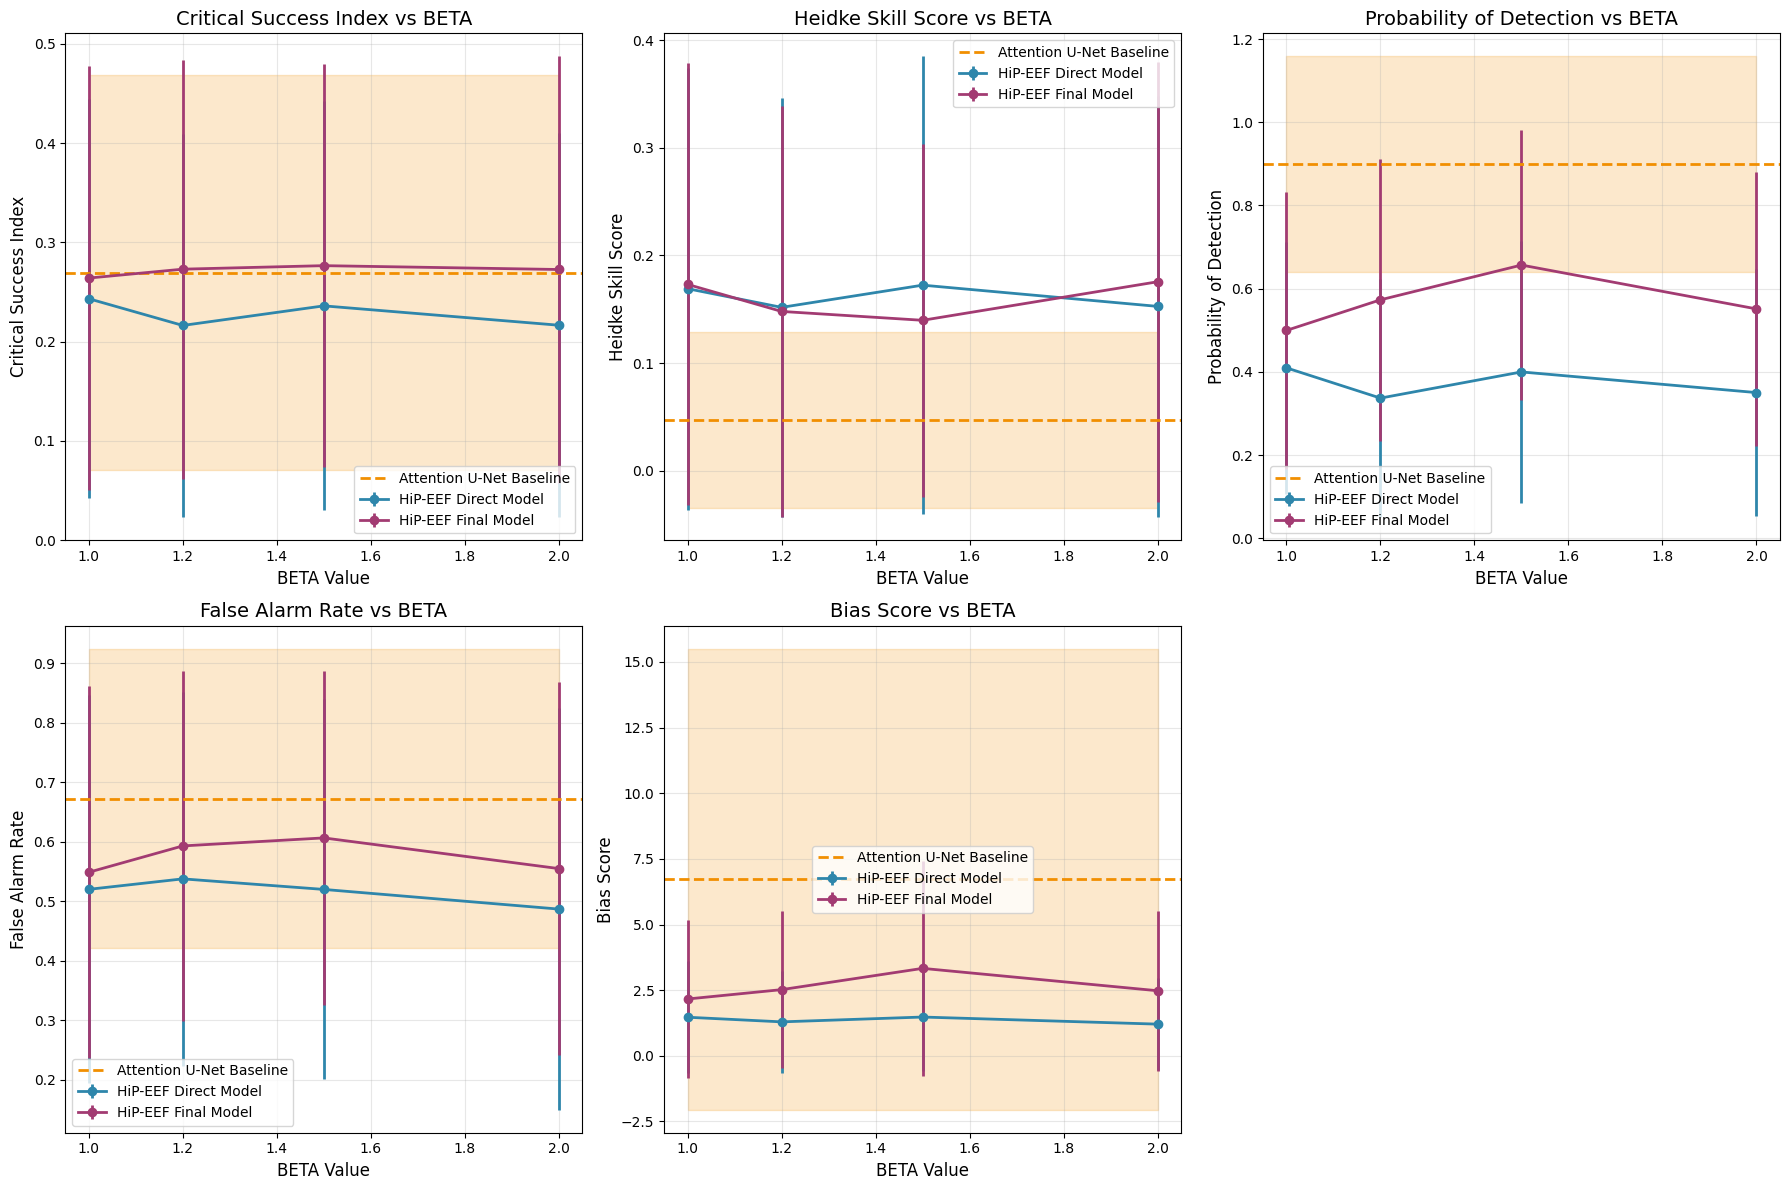

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# --- Model definitions (AttentionUNet and SimplifiedUNetAttention) stay the same ---
class SimplifiedUNetAttention(nn.Module):
    def __init__(self, channels):
        super().__init__(); self.channel_att = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(channels, channels // 16, 1), nn.ReLU(inplace=True), nn.Conv2d(channels // 16, channels, 1), nn.Sigmoid()); self.spatial_att = nn.Sequential(nn.Conv2d(channels, 1, 7, padding=3), nn.Sigmoid())
    def forward(self, x): return x * self.channel_att(x) * self.spatial_att(x)

class AttentionUNet(nn.Module):
    def __init__(self, input_channels=4, base_channels=64, depth=4):
        super().__init__(); self.depth = depth; self.channels = [base_channels * min(2**i, 8) for i in range(depth)]; self.encoders = nn.ModuleList(); self.downsamplers = nn.ModuleList(); in_ch = input_channels
        for i, out_ch in enumerate(self.channels):
          self.encoders.append(self._conv_block(in_ch, out_ch))
          if i < len(self.channels) - 1: self.downsamplers.append(nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)); in_ch = out_ch
        bn_ch = self.channels[-1]; self.bottleneck = self._conv_block(self.channels[-1], bn_ch); self.attention = SimplifiedUNetAttention(bn_ch); self.upsamplers = nn.ModuleList(); self.decoders = nn.ModuleList()
        for i in range(depth - 1, -1, -1): in_ch = bn_ch if i == depth - 1 else self.channels[i+1]; out_ch = self.channels[i]; self.upsamplers.append(nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)); self.decoders.append(self._conv_block(out_ch * 2, out_ch))
        self.final_conv = nn.Sequential(nn.Conv2d(self.channels[0], self.channels[0] // 2, 3, padding=1), nn.BatchNorm2d(self.channels[0] // 2), nn.ReLU(inplace=True), nn.Conv2d(self.channels[0] // 2, 1, 1))
    def _conv_block(self, i, o): return nn.Sequential(nn.Conv2d(i, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True), nn.Conv2d(o, o, 3, padding=1), nn.BatchNorm2d(o), nn.ReLU(inplace=True))
    def forward(self, x):
        skips = [];
        for i in range(len(self.encoders)):
          x = self.encoders[i](x); skips.append(x);
          if i < len(self.downsamplers): x = self.downsamplers[i](x)
        x = self.bottleneck(x); x = self.attention(x)
        for i, (up, dec) in enumerate(zip(self.upsamplers, self.decoders)):
            x = up(x); skip = skips[len(skips) - 1 - i];
            if x.shape[-2:] != skip.shape[-2:]: x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1); x = dec(x)
        return self.final_conv(x)

# --- CONFIGURATION ---
PROJECT_PATH = Path('/content/drive/My Drive/AR_Downscaling')
DATA_DIR = PROJECT_PATH / 'final_dataset_multi_variable'
ATTN_UNET_MODEL_PATH = PROJECT_PATH / 'publication_experiments' / 'attention_unet_final' / 'attention_unet_final_model.pth'
OUTPUT_DIR = PROJECT_PATH / 'hip_eef_comprehensive_beta_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

# Model configurations to test
BETA_VALUES = [1.0, 1.2, 1.5, 2.0]
MODEL_CONFIGS = {
    'direct_model': PROJECT_PATH / 'hip_eef_direct_model',
    'final_model': PROJECT_PATH / 'hip_eef_final_model'
}

TARGET_SHAPE = (256, 256); ALL_VARIABLES = ['IVT', 'T500', 'T850', 'RH700', 'W500']
DL_VARIABLES = ['T500', 'T850', 'RH700', 'W500']; DL_INDICES = [ALL_VARIABLES.index(v) for v in DL_VARIABLES]
THRESHOLD = 220.0; FILTER_THRESHOLD_PERCENT = 1.0

# --- UTILITY & METRICS FUNCTIONS ---
def crop_or_pad(arr, target_shape):
    h, w = arr.shape; th, tw = target_shape
    if h == th and w == tw: return arr
    start_h = max(0, (h - th) // 2); start_w = max(0, (w - tw) // 2); cropped = arr[start_h : start_h + th, start_w : start_w + tw]; h, w = cropped.shape
    if h < th or w < tw: padded = np.full(target_shape, np.nan, dtype=arr.dtype); padded[:h, :w] = cropped; return padded
    return cropped

def calculate_full_metrics(pred_k, gt_k, threshold):
    pred_mask = (pred_k <= threshold); gt_mask = (gt_k <= threshold)
    hits = np.sum(pred_mask & gt_mask); misses = np.sum(~pred_mask & gt_mask)
    false_alarms = np.sum(pred_mask & ~gt_mask); correct_negatives = np.sum(~pred_mask & ~gt_mask)

    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0.0
    hss_num = 2 * (hits * correct_negatives - false_alarms * misses)
    hss_den = (hits + misses) * (misses + correct_negatives) + (hits + false_alarms) * (false_alarms + correct_negatives)
    hss = hss_num / hss_den if hss_den > 0 else 0.0
    pod = hits / (hits + misses) if (hits + misses) > 0 else 0.0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0.0
    bias = (hits + false_alarms) / (hits + misses) if (hits + misses) > 0 else 0.0

    return {'csi': csi, 'hss': hss, 'pod': pod, 'far': far, 'bias': bias}

# --- COMPREHENSIVE ANALYSIS SCRIPT ---
def comprehensive_beta_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Starting Comprehensive BETA Analysis on {device} ---")

    # Load Attention U-Net baseline
    attn_unet_model = AttentionUNet(input_channels=len(DL_INDICES)).to(device)
    attn_unet_model.load_state_dict(torch.load(ATTN_UNET_MODEL_PATH, map_location=device))
    attn_unet_model.eval()
    print("✅ Loaded Attention U-Net baseline")

    # Load and filter test data
    test_dataset = MultiVariableARDataset(DATA_DIR, 'test')
    stats = test_dataset.stats; mean, std = stats['target_mean'], stats['target_std'] + 1e-8
    filtered_indices = [i for i in range(len(test_dataset)) if np.mean(crop_or_pad(test_dataset[i][1].numpy().squeeze(), TARGET_SHAPE) * std + mean <= THRESHOLD) * 100 > FILTER_THRESHOLD_PERCENT]
    print(f"Found {len(filtered_indices)} cases for evaluation.")

    # Store all results
    all_results = {}

    # Test all HiP-EEF configurations
    for model_type, model_dir in MODEL_CONFIGS.items():
        print(f"\n--- Testing {model_type.upper()} configurations ---")
        for beta in BETA_VALUES:
            model_path = model_dir / f'hip_eef_{model_type}_BETA_{beta}.pth'
            if not model_path.exists():
                print(f"⚠️  Model not found: {model_path}")
                continue

            # Load HiP-EEF model
            hip_eef_model = HiP_EEF_Direct(n_channels=len(DL_INDICES)).to(device)
            hip_eef_model.load_state_dict(torch.load(model_path, map_location=device))
            hip_eef_model.eval()
            print(f"✅ Loaded {model_type} BETA={beta}")

            # Evaluate this configuration
            scores = []
            for i in tqdm(filtered_indices, desc=f"{model_type} β={beta}", leave=False):
                predictor, target_norm, _ = test_dataset[i]
                gt_k = crop_or_pad(target_norm.numpy().squeeze() * std + mean, TARGET_SHAPE)

                predictor_4var = predictor[DL_INDICES, :, :].unsqueeze(0).to(device)
                with torch.no_grad():
                    hip_eef_pred_norm, _, _ = hip_eef_model(predictor_4var)

                hip_eef_pred_k = crop_or_pad(hip_eef_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)
                scores.append(calculate_full_metrics(hip_eef_pred_k, gt_k, THRESHOLD))

            all_results[f'{model_type}_beta_{beta}'] = scores

            # Clean up GPU memory
            del hip_eef_model
            torch.cuda.empty_cache()
            gc.collect()

    # Evaluate Attention U-Net baseline once
    print(f"\n--- Testing Attention U-Net Baseline ---")
    attn_scores = []
    for i in tqdm(filtered_indices, desc="Attention U-Net", leave=False):
        predictor, target_norm, _ = test_dataset[i]
        gt_k = crop_or_pad(target_norm.numpy().squeeze() * std + mean, TARGET_SHAPE)

        predictor_4var = predictor[DL_INDICES, :, :].unsqueeze(0).to(device)
        with torch.no_grad():
            attn_unet_pred_norm = attn_unet_model(predictor_4var)

        attn_unet_pred_k = crop_or_pad(attn_unet_pred_norm.cpu().numpy().squeeze() * std + mean, TARGET_SHAPE)
        attn_scores.append(calculate_full_metrics(attn_unet_pred_k, gt_k, THRESHOLD))

    all_results['attention_unet'] = attn_scores

    # --- PRINT COMPREHENSIVE RESULTS TABLE ---
    print("\n" + "="*120)
    print("                                 COMPREHENSIVE BETA ANALYSIS RESULTS")
    print("="*120)

    # Header
    header = f"{'Configuration':<25}"
    for metric in ['CSI', 'HSS', 'POD', 'FAR', 'BIAS']:
        header += f" | {metric:<15}"
    print(header)
    print("-" * 120)

    # Results for each configuration
    for config_name, scores in all_results.items():
        line = f"{config_name:<25}"
        for metric in ['csi', 'hss', 'pod', 'far', 'bias']:
            mean_score = np.mean([s[metric] for s in scores])
            std_score = np.std([s[metric] for s in scores])
            line += f" | {mean_score:.4f}±{std_score:.3f}"
        print(line)

    print("="*120)

    # --- CREATE VISUALIZATION ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    metrics = ['csi', 'hss', 'pod', 'far', 'bias']
    metric_labels = ['Critical Success Index', 'Heidke Skill Score', 'Probability of Detection', 'False Alarm Rate', 'Bias Score']

    colors = {'direct_model': '#2E86AB', 'final_model': '#A23B72', 'attention_unet': '#F18F01'}

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx]

        # Plot HiP-EEF configurations
        for model_type in MODEL_CONFIGS.keys():
            betas = []
            means = []
            stds = []
            for beta in BETA_VALUES:
                config_name = f'{model_type}_beta_{beta}'
                if config_name in all_results:
                    betas.append(beta)
                    values = [s[metric] for s in all_results[config_name]]
                    means.append(np.mean(values))
                    stds.append(np.std(values))

            if betas:  # Only plot if we have data
                ax.errorbar(betas, means, yerr=stds, marker='o', label=f'HiP-EEF {model_type.replace("_", " ").title()}',
                           color=colors[model_type], linewidth=2, markersize=6)

        # Add Attention U-Net baseline
        if 'attention_unet' in all_results:
            attn_values = [s[metric] for s in all_results['attention_unet']]
            attn_mean = np.mean(attn_values)
            attn_std = np.std(attn_values)
            ax.axhline(y=attn_mean, color=colors['attention_unet'], linestyle='--', linewidth=2,
                      label='Attention U-Net Baseline')
            ax.fill_between(BETA_VALUES, attn_mean - attn_std, attn_mean + attn_std,
                           color=colors['attention_unet'], alpha=0.2)

        ax.set_xlabel('BETA Value', fontsize=12)
        ax.set_ylabel(label, fontsize=12)
        ax.set_title(f'{label} vs BETA', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)

    # Remove the extra subplot
    axes[5].remove()

    plt.tight_layout()
    save_path = OUTPUT_DIR / 'comprehensive_beta_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Comprehensive analysis plot saved to: {save_path}")

    return all_results

if __name__ == '__main__':
    results = comprehensive_beta_analysis()